TESINA MACHINE LEARNING

CORSO: APPRENDIMENTO STATISTICO

ANNO:2021/2022

STUDENTE: GIUSEPPE BIAGIO LAPADULA s292220

Lo scopo di questa tesina è quello di testare vari algoritmi di Machine Learning su un dataset. Il dataset in questione viene descritto nella prima parte dell'elaborato. Procediamo con l'importare le varie librerie python necessarie al nostro elaborato.

In [1]:
#utilizzare come kernel per interpretare il codice venv(Python 3.9.5) che è contenuto nella cartella
import numpy as np
import scipy as sp
import scipy.linalg as lg
import jinja2
import pandas as pd
import seaborn as sb
import matplotlib as mpl
import sklearn as skl
import sklearn.neighbors
import sklearn.preprocessing as prep
import sklearn.decomposition as dec
import sklearn.cluster as clu
import sklearn.ensemble as ens
import sklearn.neighbors as neig
import sklearn.svm as svm
import sklearn.model_selection as ms
import plotly.express as px
import plotly.graph_objects as go
import random
import sklearn.discriminant_analysis as da

Dichiariamo e definiamo le function che andremo ad utilizzare in seguito nel codice

In [2]:
#function che crea un vettore di colori casuali di lunghezza n
def coloration(n):
    import matplotlib.pyplot as plt
    import random
    random.seed(random.randint(1,2500))
    no_of_colors = n
    color = ["#" + ''.join([random.choice('0123456789ABCDEF') for i in range(6)])
             for j in range(no_of_colors)]
    print(color)
    return color



#function che prende in input un modello di clustering gerarchico e ne plotta il dendrogramma
def plot_dendrogram(model, **kwargs):
    import numpy as np
    from scipy.cluster.hierarchy import dendrogram

    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



# le prossime due function permettono di costruire e plottare le confusion matrix per gli algoritmi di classificazione,
# prendendo in input le label predette e le label originali del test set.

def plot_confusion_matrix(predicted_labels_list, y_test_list,class_names):
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()



def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    import itertools
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix




# function che va a calcolare varie metriche di performance sul test set per un algoritmo di classificazione;
# essa prende in input le label predette, le label originali del test set e il numero di classi
def generate_class_metrix(predicted_targets, actual_targets,n_classes):
    import sklearn.metrics as mx
    import matplotlib as mpl
    accuracy = mx.accuracy_score(actual_targets,predicted_targets)
    precision = mx.precision_score(actual_targets,predicted_targets,average=None)
    recall = mx.recall_score(actual_targets,predicted_targets,average=None)
    specificity = np.zeros([n_classes,1])
    confMat = mx.multilabel_confusion_matrix(predicted_targets, actual_targets)
    AUC = np.zeros([n_classes,1])
    for i in range(n_classes):

        tn = confMat[i,0,0]
        fn = confMat[i,1,0]
        specificity[i] = tn/(tn + fn)
        z1 = (actual_targets==i)
        z2 = (predicted_targets == i)

        #roc = mx.roc_curve(actual_targets,predicted_targets,pos_label=i)
        roc = mx.roc_curve(z1, z2)
        fig = mpl.pyplot.figure()
        mpl.pyplot.plot(roc[0],roc[1])
        mpl.pyplot.xlabel('FNR')
        mpl.pyplot.ylabel('FPR')
        mpl.pyplot.title('ROC Curve')

        AUC[i] =mx.auc(roc[0],roc[1])

    return accuracy,precision,recall,specificity,AUC


#Le prossime 4 function servono per allenare dei modelli di classificazione e predirre con approccio 
# Cross Validation a campionamento stratificato;
# esse prendono in input la matrice dei predittori, il responso, il numero di folds con cui dividere il dataset nella
# Cross validation ed eventualmente qualche iper parametro da controllare
 
#Random Forest
def evaluate_modelRF(data_x, data_y, n_folds, n_estimators, max_depth):
    from sklearn.model_selection import StratifiedKFold

    k_fold = StratifiedKFold(n_folds, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x,data_y):
        train_x, train_y, test_x, test_y = data_x.iloc[train_ix,:], data_y.iloc[train_ix], data_x.iloc[test_ix,:], data_y.iloc[test_ix]

        # Fit the classifier
        classifier = ens.RandomForestClassifier(n_estimators = n_estimators,max_depth = max_depth).fit(train_x,train_y)

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets



#K-Nearest Neighbour
def evaluate_modelKNN(data_x, data_y,n_folds,n_neighbors):
    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import StratifiedKFold

    k_fold = StratifiedKFold(n_folds, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x,data_y):
        train_x, train_y, test_x, test_y = data_x.iloc[train_ix,:], data_y.iloc[train_ix], data_x.iloc[test_ix,:], data_y.iloc[test_ix]

        # Fit the classifier
        classifier = neig.KNeighborsClassifier(n_neighbors=n_neighbors).fit(train_x, train_y)

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets





#Support Vector Machine
def evaluate_modelSVM(data_x, data_y,n_folds,kernel):
    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import StratifiedKFold

    k_fold = StratifiedKFold(n_folds, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x,data_y):
        train_x, train_y, test_x, test_y = data_x.iloc[train_ix,:], data_y.iloc[train_ix], data_x.iloc[test_ix,:], data_y.iloc[test_ix]

        # Fit the classifier
        classifier = svm.SVC(kernel=kernel).fit(train_x, train_y)

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets




#Linear Discriminant Analysis
def evaluate_modelLDA(data_x, data_y,n_folds):
    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import StratifiedKFold
    import sklearn.discriminant_analysis as da

    k_fold = StratifiedKFold(n_folds, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x,data_y):
        train_x, train_y, test_x, test_y = data_x.iloc[train_ix,:], data_y.iloc[train_ix], data_x.iloc[test_ix,:], data_y.iloc[test_ix]

        # Fit the classifier
        classifier = da.LinearDiscriminantAnalysis().fit(train_x,train_y)

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets


#function che trasforma dei vettori di valori booleani in vettori di 0 ed 1
def booltoint(value):
    valueNew = np.ones([len(value),1])*np.nan
    for i in range(len(value)):
        if value[i] == True:
            valueNew[i] = 1

        else:
            valueNew[i] = 0

    return valueNew




Importiamo il dataset

In [3]:
#cambiare destinazione della cartella nel caso si volesse importare il dataset in un altro computer
df = pd.read_csv(r'D:\Users\Giuseppe Biagio\Desktop\POLITECNICO\Ingegneria Matematica\Apprendimento Statistico\Tesina ML Giuseppe Biagio Lapadula\Absenteeism_at_work_AAA\Absenteeism_at_work1.CSV',
                 sep=';',header=0,names=['ID','Reason for absence','Month of absence','Day of the week','Seasons','Transportation expense','Distance from Residence to Work','Service time','Age',
                                         'Work load Average/day','Hit target','Disciplinary failure','Education','Son','Social drinker','Social smoker','Pet','Weight','Height','Body mass index',
                                         'Absenteeism time in hours'])


INFORMAZIONI DATASET (esse sono state prese direttamente dal sito da cui è stato preso il dataset, al link http://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work):

Data Set Information:

The data set allows for several new combinations of attributes and attribute exclusions, or the modification of the attribute type (categorical, integer, or real) depending on the purpose of the research.The data set (Absenteeism at work - Part I) was used in academic research at the Universidade Nove de Julho - Postgraduate Program in Informatics and Knowledge Management.

Attribute Information:

1. Individual identification (ID)
2. Reason for absence (ICD).
Absences attested by the International Code of Diseases (ICD) stratified into 21 categories (I to XXI) as follows:

I Certain infectious and parasitic diseases
II Neoplasms
III Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism
IV Endocrine, nutritional and metabolic diseases
V Mental and behavioural disorders
VI Diseases of the nervous system
VII Diseases of the eye and adnexa
VIII Diseases of the ear and mastoid process
IX Diseases of the circulatory system
X Diseases of the respiratory system
XI Diseases of the digestive system
XII Diseases of the skin and subcutaneous tissue
XIII Diseases of the musculoskeletal system and connective tissue
XIV Diseases of the genitourinary system
XV Pregnancy, childbirth and the puerperium
XVI Certain conditions originating in the perinatal period
XVII Congenital malformations, deformations and chromosomal abnormalities
XVIII Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified
XIX Injury, poisoning and certain other consequences of external causes
XX External causes of morbidity and mortality
XXI Factors influencing health status and contact with health services.

And 7 categories without (CID) patient follow-up (22), medical consultation (23), blood donation (24), laboratory examination (25), unjustified absence (26), physiotherapy (27), dental consultation (28).

3. Month of absence

4. Day of the week (Monday (2), Tuesday (3), Wednesday (4), Thursday (5), Friday (6))

5. Seasons (summer (1), autumn (2), winter (3), spring (4))

6. Transportation expense

7. Distance from Residence to Work (kilometers)

8. Service time

9. Age

10. Work load Average/day

11. Hit target

12. Disciplinary failure (yes=1; no=0)

13. Education (high school (1), graduate (2), postgraduate (3), master and doctor (4))

14. Son (number of children)

15. Social drinker (yes=1; no=0)

16. Social smoker (yes=1; no=0)

17. Pet (number of pet)

18. Weight

19. Height

20. Body mass index

21. Absenteeism time in hours (target)


.arff header for Weka:

@relation Absenteeism_at_work

@attribute ID {31.0, 27.0, 19.0, 30.0, 7.0, 20.0, 24.0, 32.0, 3.0, 33.0, 26.0, 29.0, 18.0, 25.0, 17.0, 14.0, 16.0, 23.0, 2.0, 21.0, 36.0, 15.0, 22.0, 5.0, 12.0, 9.0, 6.0, 34.0, 10.0, 28.0, 13.0, 11.0, 1.0, 4.0, 8.0, 35.0}

@attribute Reason_for_absence {17.0, 3.0, 15.0, 4.0, 21.0, 2.0, 9.0, 24.0, 18.0, 1.0, 12.0, 5.0, 16.0, 7.0, 27.0, 25.0, 8.0, 10.0, 26.0, 19.0, 28.0, 6.0, 23.0, 22.0, 13.0, 14.0, 11.0, 0.0}

@attribute Month_of_absence REAL

@attribute Day_of_the_week {5.0, 2.0, 3.0, 4.0, 6.0}

@attribute Seasons {4.0, 1.0, 2.0, 3.0}

@attribute Transportation_expense REAL

@attribute Distance_from_Residence_to_Work REAL

@attribute Service_time INTEGER

@attribute Age INTEGER

@attribute Work_load_Average/day_ REAL

@attribute Hit_target REAL

@attribute Disciplinary_failure {1.0, 0.0}

@attribute Education REAL

@attribute Son REAL

@attribute Social_drinker {1.0, 0.0}

@attribute Social_smoker {1.0, 0.0}

@attribute Pet REAL

@attribute Weight REAL

@attribute Height REAL

@attribute Body_mass_index REAL

@attribute Absenteeism_time_in_hours REAL



Generiamo alcune tabelle descrittive:

Dataset

In [4]:
df

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,11,14,7,3,1,289,36,13,33,264.604,...,0,1,2,1,0,1,90,172,30,8
736,1,11,7,3,1,235,11,14,37,264.604,...,0,3,1,0,0,1,88,172,29,4
737,4,0,0,3,1,118,14,13,40,271.219,...,0,1,1,1,0,8,98,170,34,0
738,8,0,0,4,2,231,35,14,39,271.219,...,0,1,2,1,0,2,100,170,35,0


Statistiche descrittive: Correlazione variabili non categoriche e binarie (essendo la correlazione una quantità che misura le dipendenze lineari, nel caso delle variabili categoriche ha una difficile interpretabilità, dato che essa viene calcolata sui valori interi che sarebbero i "nomi" delle classi).

In [5]:
dfnoCat = df.drop(labels = ['ID','Reason for absence','Month of absence', 'Day of the week','Seasons'],axis = 1) #dataset a cui tolgo la colonna 'ID'

correlazioneDataset = dfnoCat.corr()

correlazioneDataset

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
Transportation expense,1.000000,0.262183,-0.349887,-0.227542,0.005438,-0.080193,0.109222,-0.055065,0.383001,0.145117,0.044356,0.400080,-0.207435,-0.194496,-0.136517,0.027585
Distance from Residence to Work,0.262183,1.000000,0.131730,-0.145886,-0.068677,-0.013865,-0.056527,-0.259605,0.054230,0.452196,-0.075369,0.205941,-0.047859,-0.353372,0.113772,-0.088363
Service time,-0.349887,0.131730,1.000000,0.670979,-0.000668,-0.007840,-0.000221,-0.213000,-0.047128,0.353141,0.072424,-0.440301,0.455975,-0.053135,0.499718,0.019029
Age,-0.227542,-0.145886,0.670979,1.000000,-0.039425,-0.039224,0.104304,-0.221882,0.056984,0.213183,0.121738,-0.231226,0.418730,-0.062997,0.470688,0.065760
Work load Average/day,0.005438,-0.068677,-0.000668,-0.039425,1.000000,-0.089445,0.029026,-0.074960,0.027820,-0.033713,0.030968,0.007114,-0.038522,0.103315,-0.090709,0.024749
Hit target,-0.080193,-0.013865,-0.007840,-0.039224,-0.089445,1.000000,-0.147971,0.101062,-0.014091,-0.102480,0.051254,0.007201,-0.044947,0.093267,-0.088939,0.026695
Disciplinary failure,0.109222,-0.056527,-0.000221,0.104304,0.029026,-0.147971,1.000000,-0.059298,0.072096,0.051838,0.116748,0.018881,0.072225,-0.010498,0.079428,-0.124248
Education,-0.055065,-0.259605,-0.213000,-0.221882,-0.074960,0.101062,-0.059298,1.000000,-0.188622,-0.420013,0.032727,-0.053554,-0.300574,0.100977,-0.366884,-0.046235
Son,0.383001,0.054230,-0.047128,0.056984,0.027820,-0.014091,0.072096,-0.188622,1.000000,0.206376,0.156088,0.108917,-0.139552,-0.014208,-0.144150,0.113756
Social drinker,0.145117,0.452196,0.353141,0.213183,-0.033713,-0.102480,0.051838,-0.420013,0.206376,1.000000,-0.111678,-0.122780,0.378664,0.169951,0.323978,0.065067


In [6]:
indici = np.argwhere(abs(correlazioneDataset.values)>0.5)
indiciUtili= []
for i in range(np.size(indici,axis=0)):
    if indici[i][1] != indici[i][0]:
        indiciUtili.append(indici[i])
indiciUtili

[array([2, 3], dtype=int64),
 array([3, 2], dtype=int64),
 array([12, 14], dtype=int64),
 array([14, 12], dtype=int64)]

Quello che possiamo notare è che in generale i dati non hanno fra di essi correlazioni molto elevate, l'assuzione base del Machine Learning può essere presa relativamente con tranquillità; in particolare,le coppie di features che hanno una correlazione superiore a 0.5 sono: Age - Service time (0.670979) e Wheight-Body Mass index (0.904117, molto alta proprio perchè il BMI si calcola in funzione del peso corporeo).
Altri valori di correlazione meno elevati(sia positivamente che negativamente) si possono riscontrare in features come ad esempio "Social Drinker", che mostra ad esempio una correlazione negativa con "Education"(variabile categorica  che però è facilmente interpretabile, poichè all'aumentare del suo valore aumenta anche il livello di educazione) pari a -0.420013, oppure una correlazione positiva con "Distance from Residence to Work" di 0.452196.

Statistiche dati non categorici:

In [7]:
statsCount = df.drop(labels = ['ID','Month of absence','Reason for absence','Day of the week','Seasons','Disciplinary failure','Education','Social drinker','Social smoker'],axis=1)

text = statsCount.describe()

text

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Son,Pet,Weight,Height,Body mass index,Absenteeism time in hours
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,221.329730,29.631081,12.554054,36.450000,271.490235,94.587838,1.018919,0.745946,79.035135,172.114865,26.677027,6.924324
std,66.952223,14.836788,4.384873,6.478772,39.058116,3.779313,1.098489,1.318258,12.883211,6.034995,4.285452,13.330998
min,118.000000,5.000000,1.000000,27.000000,205.917000,81.000000,0.000000,0.000000,56.000000,163.000000,19.000000,0.000000
25%,179.000000,16.000000,9.000000,31.000000,244.387000,93.000000,0.000000,0.000000,69.000000,169.000000,24.000000,2.000000
50%,225.000000,26.000000,13.000000,37.000000,264.249000,95.000000,1.000000,0.000000,83.000000,170.000000,25.000000,3.000000
75%,260.000000,50.000000,16.000000,40.000000,294.217000,97.000000,2.000000,1.000000,89.000000,172.000000,31.000000,8.000000
max,388.000000,52.000000,29.000000,58.000000,378.884000,100.000000,4.000000,8.000000,108.000000,196.000000,38.000000,120.000000


Le statistiche contenute in questa tabella vengono mostrate graficamente nei seguenti boxplot; Possiamo comunque notare che i dati con una variabilità molto elevata sono quelli relativi alle features 'Transportation expense', che ha una elevata variabilità nel valore del dato(notare che è il valore con la deviazione standard più alta), oppure 'Pet', 'Height' o 'Absenteeism time in hours', in cui si può notare una consistente presenza di outliers.

Boxplot dati non categorici:

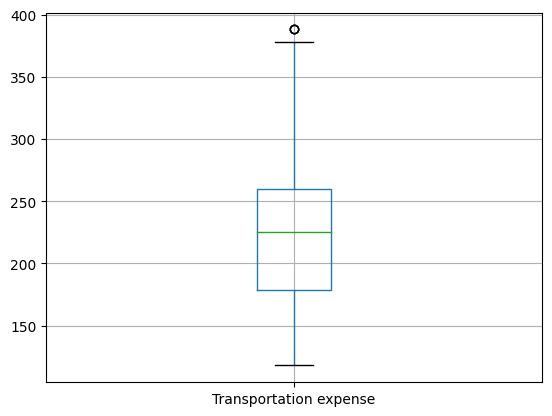

In [8]:
boxplotDati2 = df.boxplot(column = ['Transportation expense'])
mpl.pyplot.show()

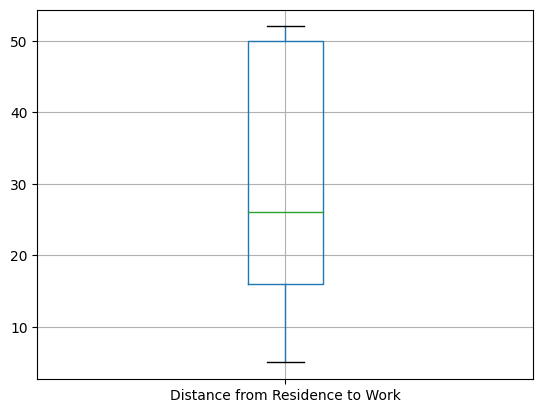

In [9]:
boxplotDati3 = df.boxplot(column = ['Distance from Residence to Work'])
mpl.pyplot.show()

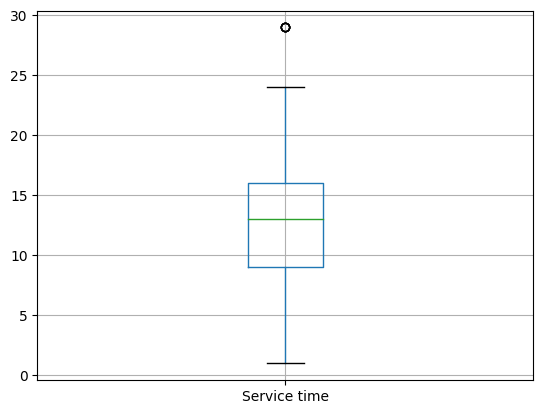

In [10]:
boxplotDati4 = df.boxplot(column = ['Service time'])
mpl.pyplot.show()

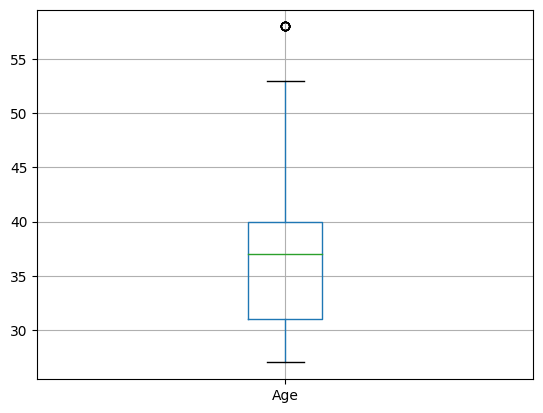

In [11]:
boxplotDati5 = df.boxplot(column = ['Age'])
mpl.pyplot.show()

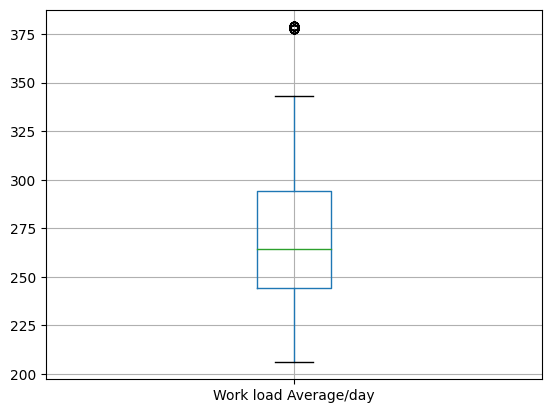

In [12]:
boxplotDati6 = df.boxplot(column = ['Work load Average/day'])
mpl.pyplot.show()

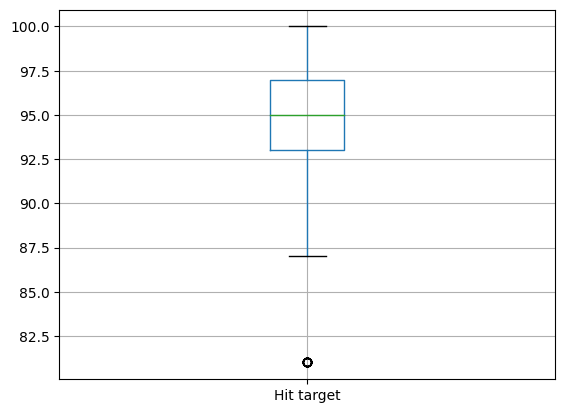

In [13]:
boxplotDati7 = df.boxplot(column = ['Hit target'])
mpl.pyplot.show()

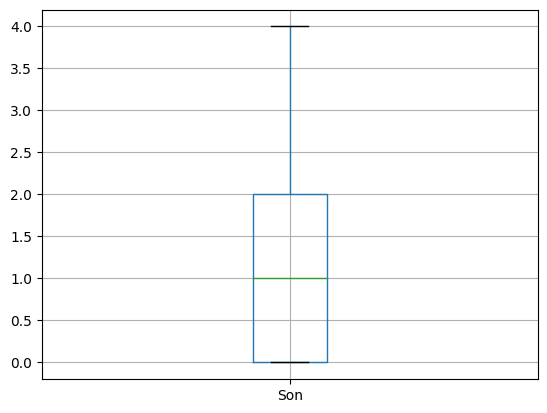

In [14]:
boxplotDati9 = df.boxplot(column = ['Son'])
mpl.pyplot.show()

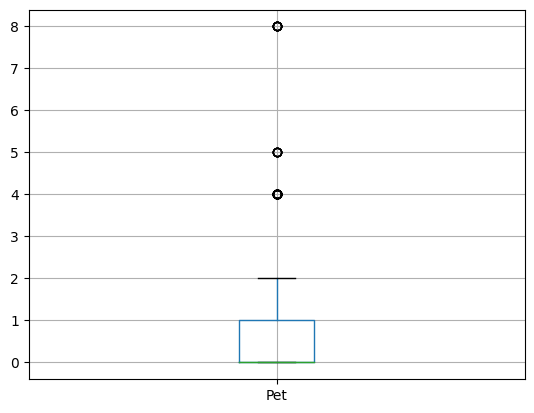

In [15]:
boxplotDati10 = df.boxplot(column = ['Pet'])
mpl.pyplot.show()

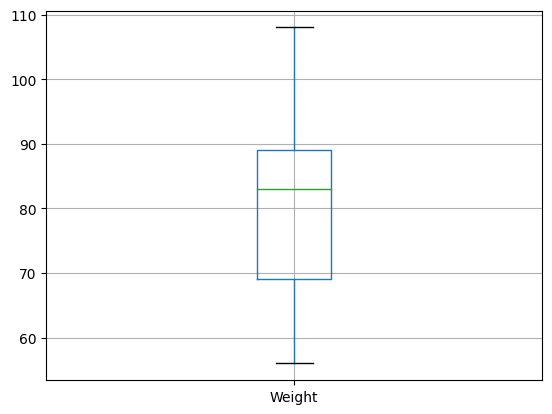

In [16]:
boxplotDati11 = df.boxplot(column = ['Weight'])
mpl.pyplot.show()

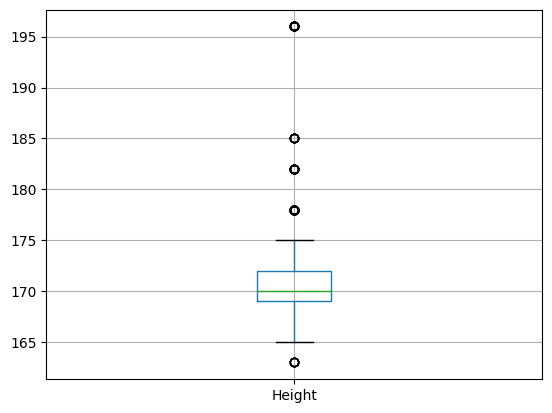

In [17]:
boxplotDati12 = df.boxplot(column = ['Height'])
mpl.pyplot.show()

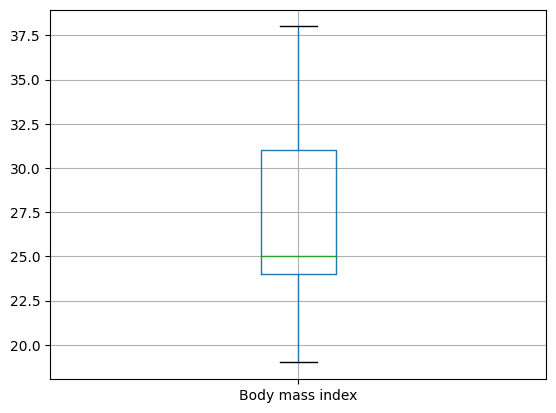

In [18]:
boxplotDati13 = df.boxplot(column = ['Body mass index'])
mpl.pyplot.show()

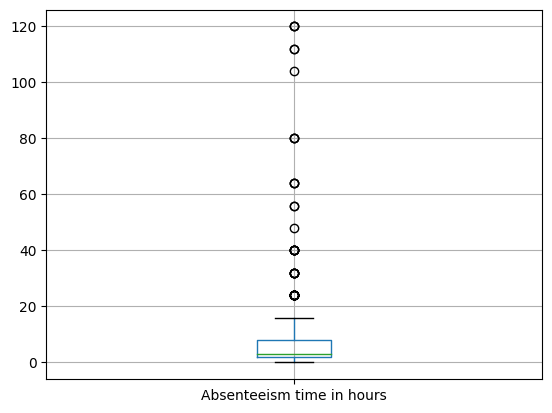

In [19]:
boxplotDati14 = df.boxplot(column = ['Absenteeism time in hours'])
mpl.pyplot.show()

In quest'ultimo grafico, relativo alla variabile target Absenteeism time in hours, notiamo la presenza di diversi possibili "outliers" nella distribuzione dei dati, raggruppati su specifici valori.

Istogrammi dati non categorici

Anche dai seguenti istogrammi riusciamo a vedere alcune caratteristiche dei riscontrate in precedenza, come la presenza di diversi outliers in alcuni attributi, oppure riusciamo anche a comprendere che i nostri record non sono sempre distribuiti secondo il grafico usuale di una "Normale", ma eventualmente notiamo anche picchi di frequenze differenti, come ad esempio si può notare in 'Distance from residence to work', dove potremmo individuare una frequenza elevata intorno alla mediana, ma allo stesso tempo ci sono altre colonne elevate in corrispondenza di valori considerati "outliers", o comunque lontani dal valore della mediana.

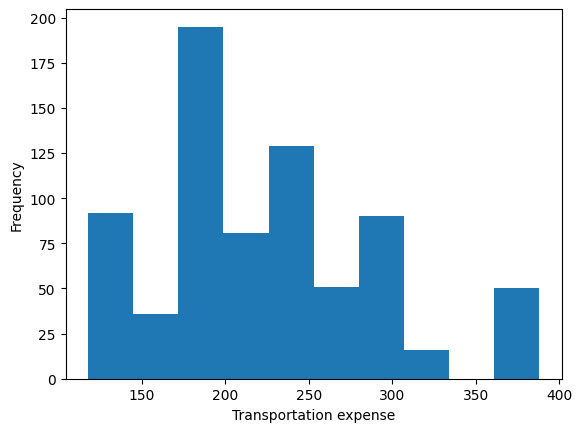

In [20]:
hinstogram2 = df['Transportation expense'].plot.hist()
mpl.pyplot.xlabel('Transportation expense')
mpl.pyplot.show()

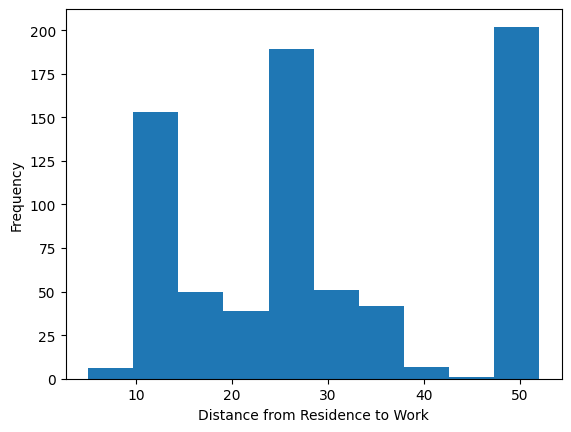

In [21]:
hinstogram3 = df['Distance from Residence to Work'].plot.hist()
mpl.pyplot.xlabel('Distance from Residence to Work')
mpl.pyplot.show()

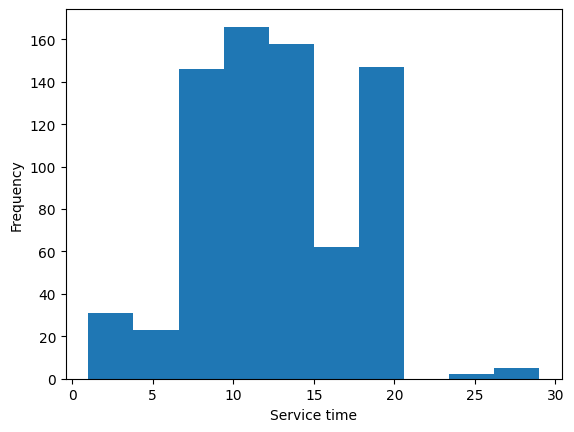

In [22]:
hinstogram4 = df['Service time'].plot.hist()
mpl.pyplot.xlabel('Service time')
mpl.pyplot.show()

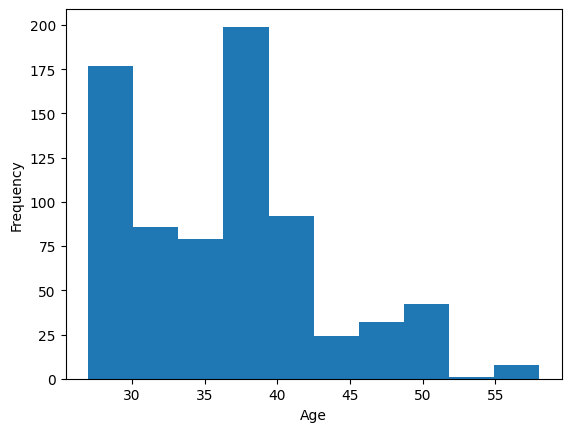

In [23]:
hinstogram5 = df['Age'].plot.hist()
mpl.pyplot.xlabel('Age')
mpl.pyplot.show()

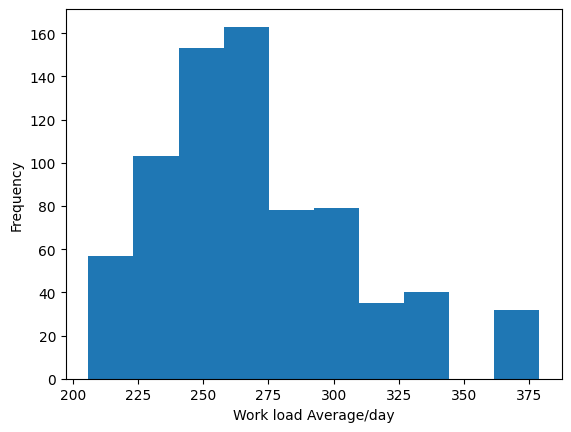

In [24]:
hinstogram6 = df['Work load Average/day'].plot.hist()
mpl.pyplot.xlabel('Work load Average/day')
mpl.pyplot.show()

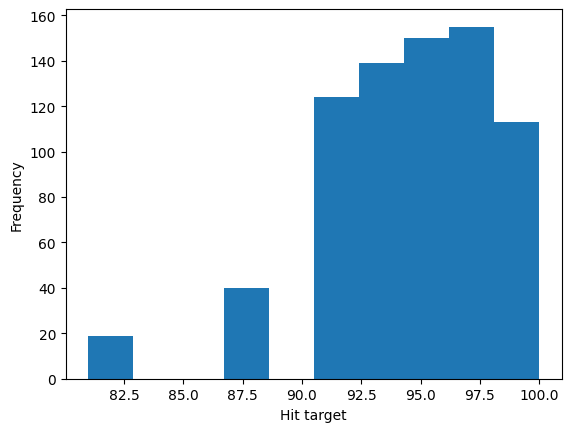

In [25]:
hinstogram7 = df['Hit target'].plot.hist()
mpl.pyplot.xlabel('Hit target')
mpl.pyplot.show()

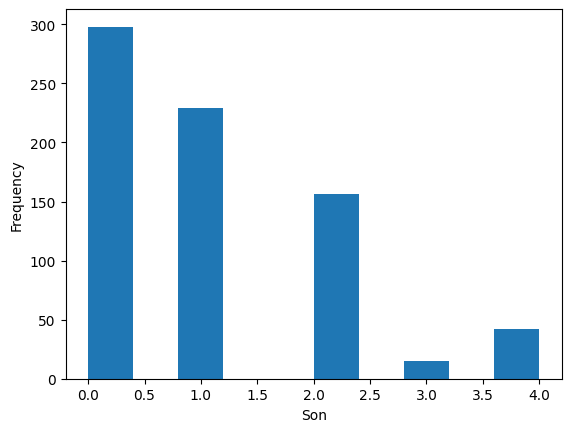

In [26]:
hinstogram9 = df['Son'].plot.hist()
mpl.pyplot.xlabel('Son')
mpl.pyplot.show()

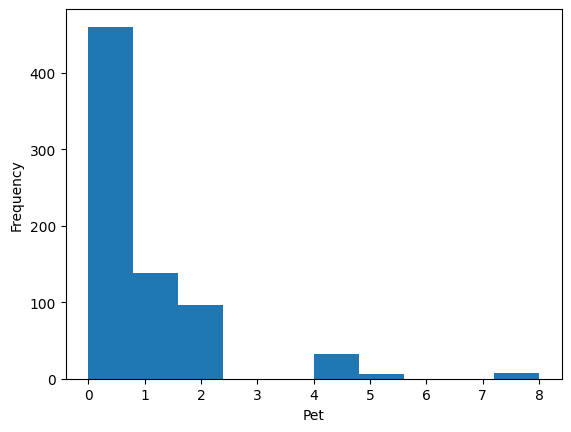

In [27]:
hinstogram10 = df['Pet'].plot.hist()
mpl.pyplot.xlabel('Pet')
mpl.pyplot.show()


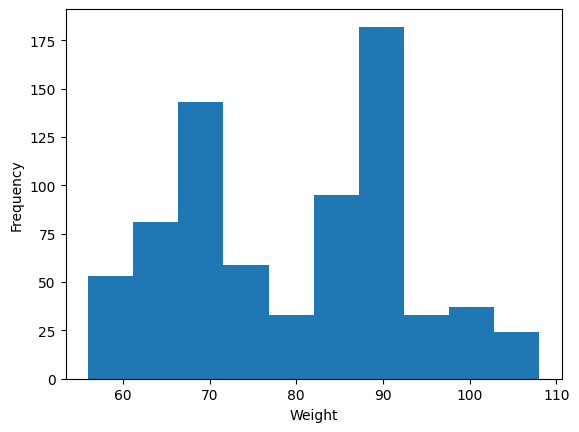

In [28]:
hinstogram11 = df['Weight'].plot.hist()
mpl.pyplot.xlabel('Weight')
mpl.pyplot.show()

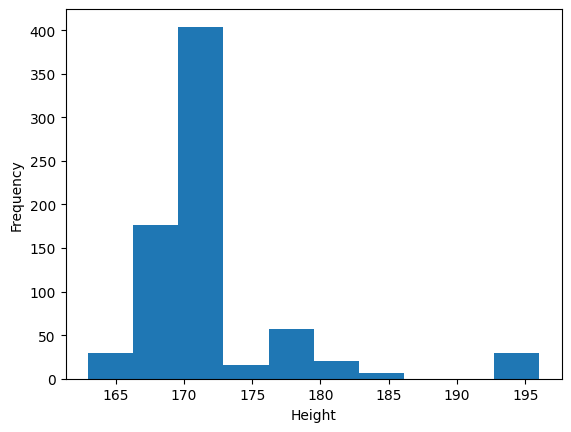

In [29]:
hinstogram12 = df['Height'].plot.hist()
mpl.pyplot.xlabel('Height')
mpl.pyplot.show()

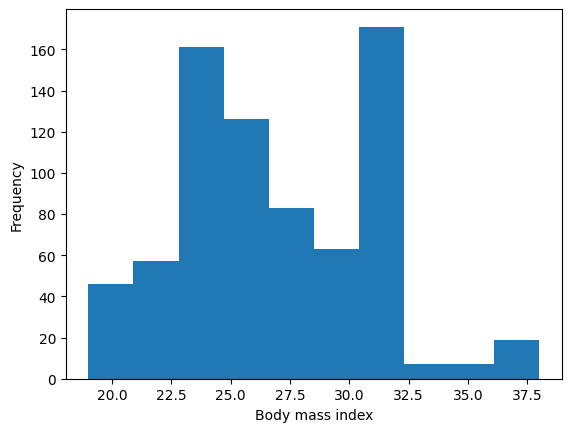

In [30]:
hinstogram13 = df['Body mass index'].plot.hist()
mpl.pyplot.xlabel('Body mass index')
mpl.pyplot.show()

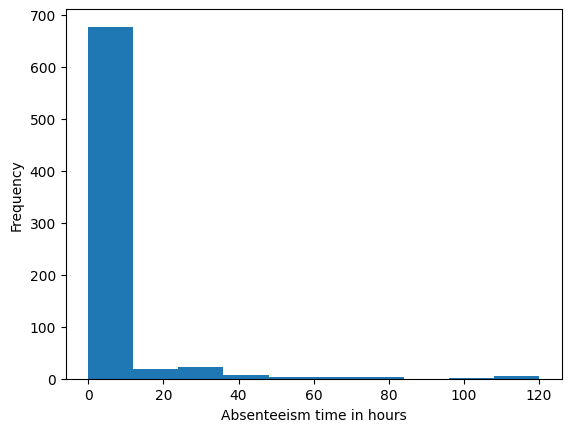

In [31]:
hinstogram14 = df['Absenteeism time in hours'].plot.hist()
mpl.pyplot.xlabel('Absenteeism time in hours')
mpl.pyplot.show()

Plot statistiche descrittive dati categorici (diagrammi a barre e a torta)

Questi plot ci aiutano a comprendere la distribuzione dei dati categorici, in funzione dell'attributo ID.

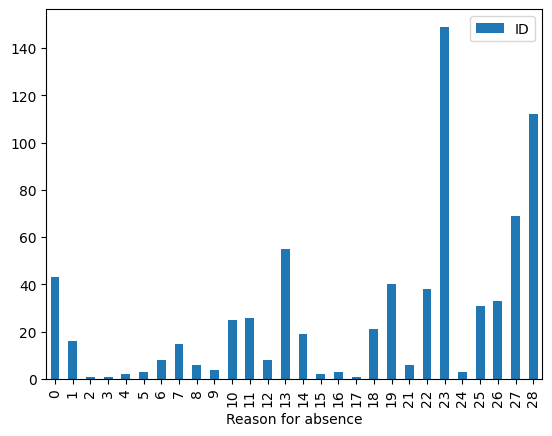

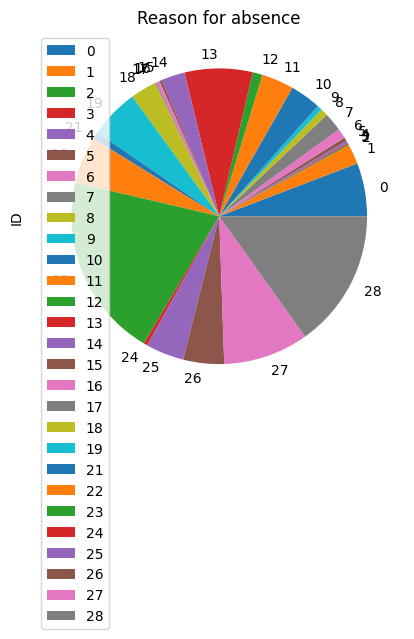

In [32]:
count1 = df[['ID','Reason for absence']].groupby(['Reason for absence']).count()
barplot1 = count1.plot.bar()
pieplot1 = count1.plot.pie(y='ID')
mpl.pyplot.title('Reason for absence')
mpl.pyplot.show()

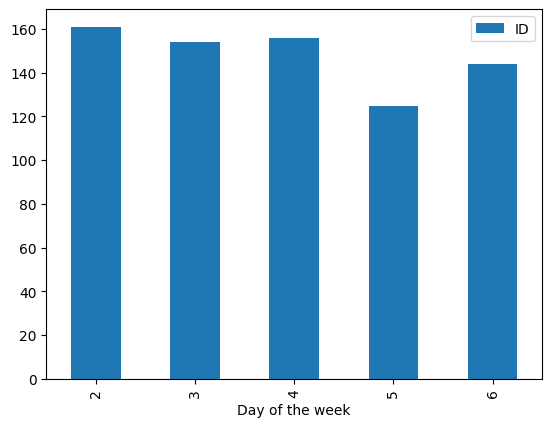

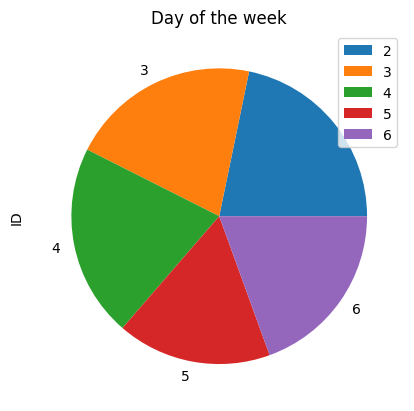

In [33]:
count2 = df[['ID','Day of the week']].groupby(['Day of the week']).count()
barplot2 = count2.plot.bar()
pieplot2 = count2.plot.pie(y='ID')
mpl.pyplot.title('Day of the week')
mpl.pyplot.show()

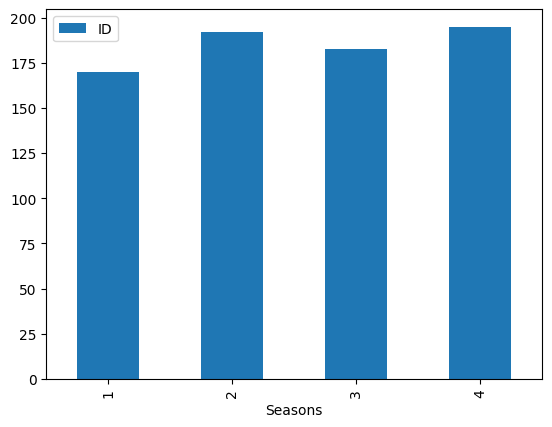

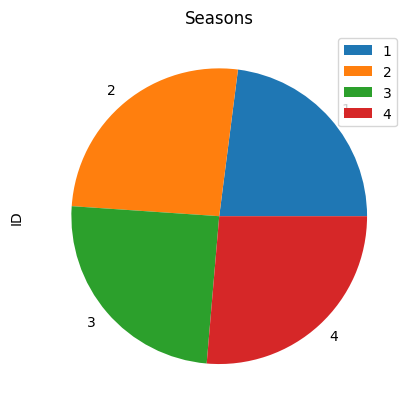

In [34]:
count3 = df[['ID','Seasons']].groupby(['Seasons']).count()
barplot3 = count3.plot.bar()
pieplot3 = count3.plot.pie(y='ID')
mpl.pyplot.title('Seasons')
mpl.pyplot.show()

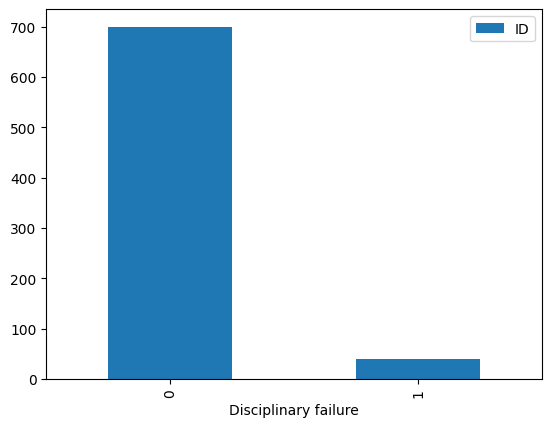

In [35]:
count4 = df[['ID','Disciplinary failure']].groupby(['Disciplinary failure']).count()
barplot4 = count4.plot.bar()
mpl.pyplot.show()


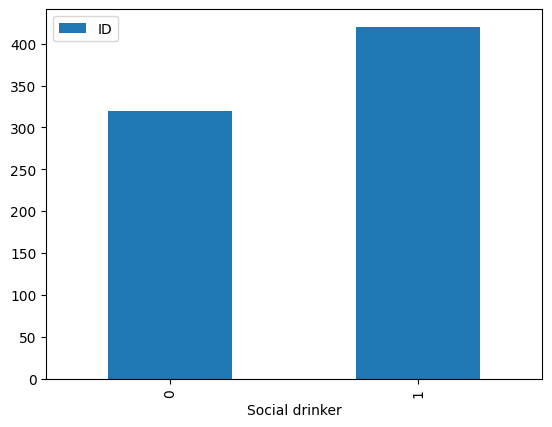

In [36]:
count5 = df[['ID','Social drinker']].groupby(['Social drinker']).count()
barplot5 = count5.plot.bar()
mpl.pyplot.show()


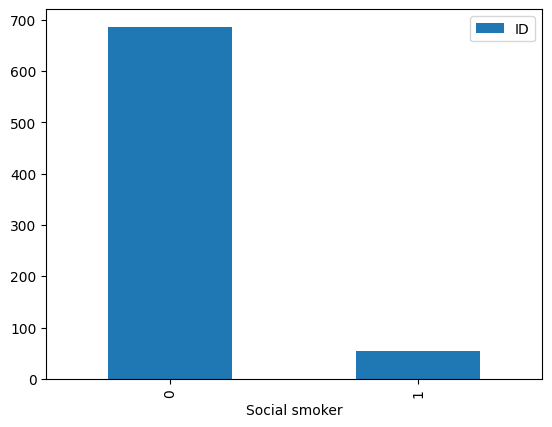

In [37]:
count6 = df[['ID','Social smoker']].groupby(['Social smoker']).count()
barplot6 = count6.plot.bar()
mpl.pyplot.show()


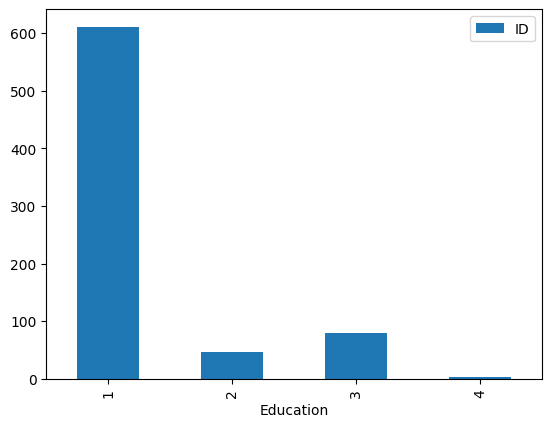

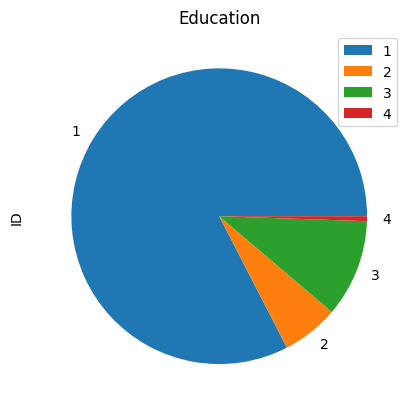

In [38]:
count7 = df[['ID','Education']].groupby(['Education']).count()
barplot7 = count7.plot.bar()
pieplot7 = count7.plot.pie(y='ID')
mpl.pyplot.title('Education')
mpl.pyplot.show()

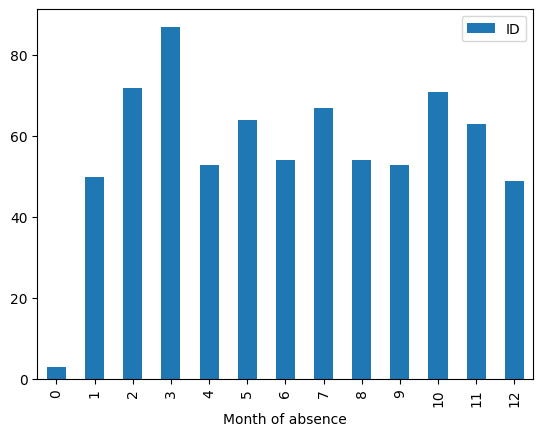

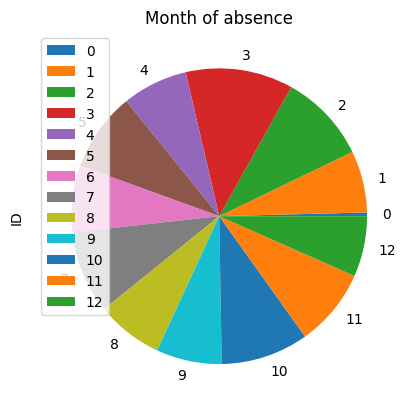

In [39]:
count8 = df[['ID','Month of absence']].groupby(['Month of absence']).count()
barplot8 = count8.plot.bar()
pieplot8 = count8.plot.pie(y='ID')
mpl.pyplot.title('Month of absence')
mpl.pyplot.show()

Una volta caratterizzato il dataset, possiamo procedere all'applicazione delle varie tecniche di Machine Learning che conosciamo. Si procederà prima utilizzando gli algoritmi di Unsupervised Learning, poichè ci possono aiutare ad avere informazioni utili sul dataset che non salterebbero al'occhio, senza la pretesa di dover effettuare una predizione. 

In prima analisi, utilizzeremo la tecnica della PCA per poter vedere com'è possibilie ridurre la dimensionalità del dataset. La PCA infatti è una tecnica che va a proiettare il nostro "iperpiano" dei dati di dimensione nominale q su un iperpiano di dimensione p, tale che p < q; La base dell'iperpiano su cui vogliamo proiettare il dataset è data da combinazioni lineari delle nostre features (il nostro dataset ha dimensione NumeroRecords x q), che saranno le "features" di un nuovo dataset, di dimensione NumeroRecords x p, tali che esse possano "spiegare" la maggior parte della varianza: l'idea in particolare è quella di massimizzare la varianza rappresentata risolvendo il problema di massimizzazione sul loading vector(vettore con le componenti della componente principale) della varianza campionaria sui dati ripriettati lungo la componente principale (cioè massimizziamo la varianza campionaria di Phi'X, dove Phi è il loading vector, e si impone il vincolo sum(Phi_j^2) = 1)); inoltre, queste nuove features ottenute saranno mutualmente non correlate.



1) PCA su tutte le features


Per poter effettuare la PCA si richiede di avere un dataset formato da attributi reali. Per questo dobbiamo trasformare le features categoriche in reali, splittandole prima in variabili booleane effettuando un One-Hot encoding ed in seguito rilassare le variabili booleane ottenute, rendendole continue (in [0,1]).

In [40]:
dfOHE = df.drop(labels = ['ID','Month of absence','Reason for absence','Day of the week','Seasons','Education','Social drinker','Social smoker','Disciplinary failure'],axis=1)


encoder = prep.OneHotEncoder(handle_unknown='ignore')
dfOHE1 = pd.DataFrame(encoder.fit_transform(df[['Reason for absence']]).toarray())
dfOHE1 = pd.DataFrame(data = dfOHE1.values,columns=['Reason for absence = 1','Reason for absence = 2','Reason for absence = 3','Reason for absence = 4','Reason for absence = 5','Reason for absence = 6','Reason for absence = 7','Reason for absence = 8',
                                                    'Reason for absence = 9','Reason for absence = 10','Reason for absence = 11','Reason for absence = 12','Reason for absence = 13','Reason for absence = 14','Reason for absence = 15','Reason for absence = 16','Reason for absence = 17','Reason for absence = 18',
                                                    'Reason for absence = 19','Reason for absence = 20','Reason for absence = 21','Reason for absence = 22','Reason for absence = 23','Reason for absence = 24','Reason for absence = 25','Reason for absence = 26','Reason for absence = 27','Reason for absence = 28'])

dfOHE2 = pd.DataFrame(encoder.fit_transform(df[['Day of the week']]).toarray())
dfOHE2 = pd.DataFrame(data = dfOHE2.values,columns=['Day of the week = 2','Day of the week = 3','Day of the week = 4','Day of the week = 5','Day of the week = 6'])
dfOHE3 = pd.DataFrame(encoder.fit_transform(df[['Seasons']]).toarray())
dfOHE3 = pd.DataFrame(data = dfOHE3.values,columns=['Seasons = 1','Seasons = 2','Seasons = 3','Seasons = 4'])
dfOHE4 = pd.DataFrame(encoder.fit_transform(df[['Education']]).toarray())
dfOHE4 = pd.DataFrame(data = dfOHE4.values,columns=['Education = 1','Education = 2','Education = 3','Education = 4'])
dfOHE5 = pd.DataFrame(encoder.fit_transform(df[['Month of absence']]).toarray())
dfOHE5 = pd.DataFrame(data = dfOHE5.values,columns=['Month of absence =0','Month of absence =1','Month of absence =2','Month of absence =3','Month of absence =4','Month of absence =5','Month of absence =6','Month of absence =7','Month of absence =8','Month of absence =9','Month of absence =10','Month of absence =11','Month of absence =12'])



Ora bisogna standardizzare le variabili che in origine erano non categoriche, per poter applicare la PCA.
Alla fine otteniamo un nuovo dataset, a cui inoltre abbiamo tolto la feature "ID".

In [41]:
medie = dfOHE.mean()
dfStd = dfOHE - medie
dfStd = dfStd/(np.diag(dfOHE.cov()))
dfStd = dfStd.join(other=[df['Social drinker'],df['Social smoker'],df['Disciplinary failure'],dfOHE1,dfOHE2,dfOHE3,dfOHE4,dfOHE5])
dfStd

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Son,Pet,Weight,Height,...,Month of absence =3,Month of absence =4,Month of absence =5,Month of absence =6,Month of absence =7,Month of absence =8,Month of absence =9,Month of absence =10,Month of absence =11,Month of absence =12
0,0.015096,0.028932,0.023194,-0.082193,-0.020934,0.168881,0.813043,0.146193,0.066063,-0.003154,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.023051,-0.075551,0.283243,0.322815,-0.020934,0.168881,-0.015679,-0.429246,0.114262,0.161586,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.009443,0.097074,0.283243,0.036927,-0.020934,0.168881,-0.844400,-0.429246,0.060038,-0.058067,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.012865,-0.111893,0.075203,0.060751,-0.020934,0.168881,0.813043,-0.429246,-0.066486,-0.112980,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.015096,0.028932,0.023194,-0.082193,-0.020934,0.168881,0.813043,0.146193,0.066063,-0.003154,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,0.015096,0.028932,0.023194,-0.082193,-0.004514,-0.111168,0.813043,0.146193,0.066063,-0.003154,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
736,0.003050,-0.084637,0.075203,0.013103,-0.004514,-0.111168,-0.015679,0.146193,0.054013,-0.003154,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
737,-0.023051,-0.071008,0.023194,0.084575,-0.000178,0.028856,-0.015679,4.174263,0.114262,-0.058067,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
738,0.002157,0.024390,0.075203,0.060751,-0.000178,0.028856,0.813043,0.721631,0.126312,-0.058067,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ora quindi possiamo procedere ad effettuare la PCA. Siccome noi vogliamo bilanciare il traedoff tra ridurre la dimensionalità del dataset e catturare la massima varianza possibile, possiamo procedere sfruttando la tecnica del "gomito": plotteremo infatti il grafico del rapporto di varianza spiegata, e prenderemo il numero di componenti in cui si va a formare un "gomito". Quelle componenti principali ottenute ci rappresenteranno la percentuale di varianza descritta nel successivo grafico che rappresenta la somma cumulativa di questi rapporti.

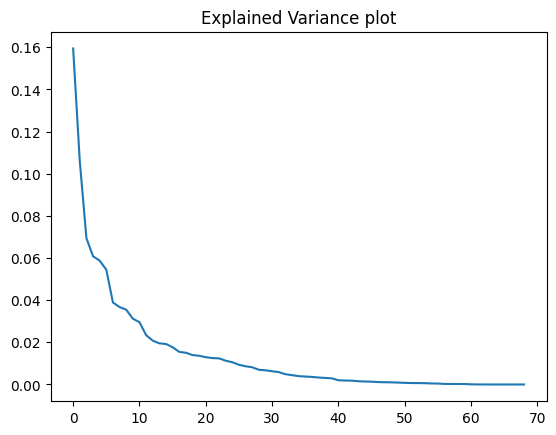

In [42]:
pca = dec.PCA()
pca.fit(dfStd)

evr = pca.explained_variance_ratio_
mpl.pyplot.plot(evr)
mpl.pyplot.title('Explained Variance plot')
mpl.pyplot.show()

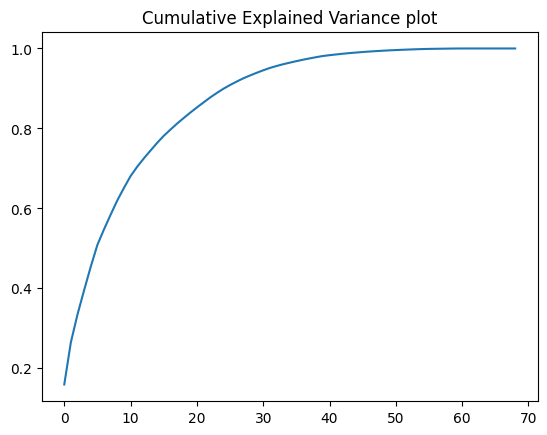

array([0.1594035 , 0.26539571, 0.33484474, 0.39566103, 0.4544043 ,
       0.50886092, 0.5477667 , 0.58449124, 0.6199743 , 0.65119912,
       0.68076276, 0.70420249, 0.72498678, 0.7445053 , 0.76371668,
       0.78140407, 0.79686537, 0.81192113, 0.8258729 , 0.83949623,
       0.85244179, 0.86497069, 0.87735762, 0.88864846, 0.89920989,
       0.90857286, 0.9172047 , 0.92537831, 0.93236263, 0.93908421,
       0.94536265, 0.95123986, 0.95612201, 0.96054189, 0.96450343,
       0.96827752, 0.97187031, 0.97516415, 0.97826888, 0.98118585,
       0.98319168, 0.98506426, 0.98687633, 0.98842103, 0.98982979,
       0.99116731, 0.99230517, 0.99338231, 0.99438779, 0.99529363,
       0.99606373, 0.99674043, 0.99740379, 0.99802154, 0.99851061,
       0.99895142, 0.99921375, 0.99946273, 0.99968796, 0.99990948,
       0.9999769 , 0.99999544, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [43]:
mpl.pyplot.plot(np.cumsum(evr))
mpl.pyplot.title('Cumulative Explained Variance plot')
mpl.pyplot.show()
np.cumsum(evr)


Dai grafici mostrati qui sopra, siamo giunti alla conclusione che in questo caso il numero di features corrispondente ad un possibile gomito che è stato scelto corrisponde a 10 componenti principali, le quali catturano il 65.11 % della varianza totale.

Ora andremo invece a plottare le prime 3 componenti principali ottenute e la loro varianza spiegata. Si può notare che i punti dello scatter scelti variano il colore in base all'attributo "ID". Quello che possiamo notare è che anche se esso è stato tolto dal dataset utilizzato nella PCA,  riesce comunque a caratterizzare le nostre features, raggruppandole in gruppi sul piano PC1-PC2: ciò è dovuto al fatto che l'attributo ID rappresenta l'ID del lavoratore su cui è stata preso il dato e non l'ID del dato stesso. Quindi più record possono avere lo stesso valore per la feature "ID", che in alcune situazioni tende ad avere sempre gli stessi valori sul piano PC1-PC2, riuscendo quindi ad evidenziare il comportamento specifico di un singolo lavoratore sulle prime due componenti principali.

In [44]:
pcaEl = dec.PCA(n_components=3)
pcaEl.fit(dfStd)
pcaEl.fit_transform(dfStd)


components = pcaEl.fit_transform(dfStd)

explVar3 = sum(pcaEl.explained_variance_ratio_)*100
fig = px.scatter_3d(
    components, x=0, y=1, z=2,
    title=f'Total Explained Variance: {explVar3:.2f}%', color=df['ID'],
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()




Scatter matrix con le prime 4 componenti principali. Notiamo un comportamento analogo al grafico precedente tra PC1 e PC2. In particolare notiamo una formazione di gruppi di dati anche sugli altri piani, corrispondenti ad uno specifico lavoratore.

In [45]:

pcaEl = dec.PCA(n_components=10)
pcaEl.fit(dfStd)
pcaEl.fit_transform(dfStd)

dfPCA = pd.DataFrame(pcaEl.transform(dfStd))
components = dfPCA.values
components = components[:,0:4]


labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pcaEl.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=df["ID"]
)
fig.update_traces(diagonal_visible=False)

fig.show()

In ultimo mostriamo il loading plot dei nostri dati sulle prime due componenti principali, ossia vogliamo vedere come gli assi principali delle nostre features originali(del dataset utilizzato per la PCA) vengono rappresentate sul piano PC1-PC2.
Per comodità di visualizzazione, i loadings sono normalizzati e riscalati di un fattore 4.

In [46]:
features = dfStd.columns
X = dfStd


loadings = pcaEl.components_.T * np.sqrt(pcaEl.explained_variance_)
loadings = 4*np.array([pow(lg.norm(loadings,axis=1),-1)*loadings[:,0],pow(lg.norm(loadings,axis=1),-1)*loadings[:,1],pow(lg.norm(loadings,axis=1),-1)*loadings[:,2]]).T

fig = px.scatter(components, x=0, y=1,color=df['ID'])

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()


Da questo grafico possiamo estrapolare tante informazioni. Ad esempio, se guardiamo l'attributo "Pet", notiamo che in corrispondenza di esso si ottengono diversi gruppi isolati di dati(che tendono a seguire l'andamento degli outliers visti all'inizio), che seguono la sua linea sul loading plot, facendo vedere che esso ha quindi una certa importanza nel contesto della creazione delle due prime componenti principali.

Adesso procederemo con lo studio della PCA solo sugli attrubuti non categorici. Quindi salteremo la parte del One-Hot Encoding, effettuando una standardizzazione degli attributi utilizzati.

In [47]:
dfReal = df.drop(labels = ['ID','Month of absence','Reason for absence','Day of the week','Seasons','Education','Social drinker','Social smoker','Disciplinary failure'],axis=1)

#Standardizzazione variabili non categoriche
medie = dfReal.mean()
dfStd = dfReal - medie
dfStd = dfStd/(np.diag(dfReal.cov()))

pca = dec.PCA()
pca.fit(dfStd)

PCA()

Studiamo di nuovo la varianza spiegata per poter valutare qual è il numero di componenti da scegliere.

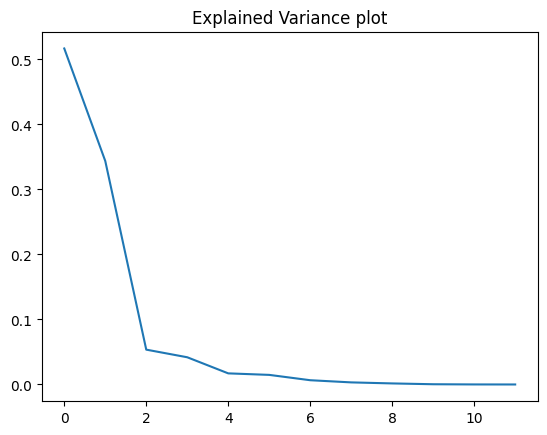

In [48]:
evr = pca.explained_variance_ratio_
mpl.pyplot.plot(evr)
mpl.pyplot.title('Explained Variance plot')
mpl.pyplot.show()

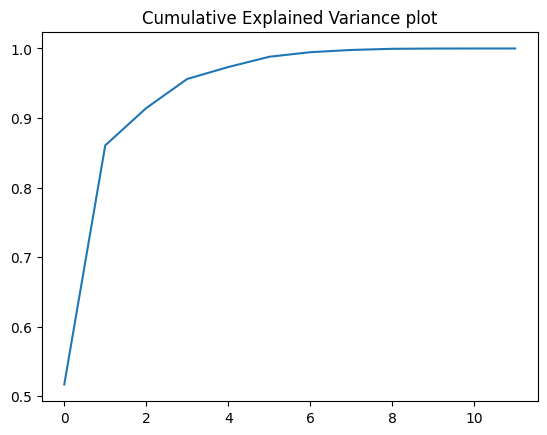

array([0.51687786, 0.86069573, 0.91430823, 0.95618943, 0.97330071,
       0.98807516, 0.9946379 , 0.99787312, 0.99951604, 0.99989742,
       0.99998042, 1.        ])

In [49]:
mpl.pyplot.plot(np.cumsum(evr))
mpl.pyplot.title('Cumulative Explained Variance plot')
mpl.pyplot.show()
np.cumsum(evr)

Quello che ci suggerisce il grafico è che potremmo scegliere già solo 3 componenti per ottenere il 91% della varianza, che si trova all'interno del gomito.
Di seguito verranno plottati gli stessi grafici precedenti.

Scatterplot componenti principali: l'andamento della distribuzione di punti è relativamente simile a quella ottenuta con la PCA effettuata sull'intero dataset, con un andamento possibilmente molto più ordinato, in cui riusciamo quasi ad individuare delle classi ben distinte, a volte riconducibili al valore della classe "ID".

In [50]:
pcaEl = dec.PCA(n_components=3)
pcaEl.fit(dfStd)
pcaEl.fit_transform(dfStd)

components = pcaEl.fit_transform(dfStd)

explVar3 = sum(pcaEl.explained_variance_ratio_)*100
fig = px.scatter_3d(
    components, x=0, y=1, z=2,
    title=f'Total Explained Variance: {explVar3:.2f}%', color=df['ID'],
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()


Scatterplot multiplo sulle 3 componenti ottenute dalla PCA. Da notare i valori riuniti in "classi" nel piano PC1-PC2.

In [51]:
dfPCA = pd.DataFrame(pcaEl.transform(dfStd))
components = dfPCA.values
components = components[:,0:3]


labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pcaEl.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3),
    color=df["ID"]
)
fig.update_traces(diagonal_visible=False)

fig.show()


In [52]:

#riproietto all'indietro ed ottengo il nuovo dataset
dfStdOD = pd.DataFrame(pcaEl.inverse_transform(dfPCA),columns=dfStd.columns)


Loading plot. Anche qui si può notare, come nel caso precedente, come i Loading vectors vadano ad influenzare le nostre componenti principali, citando ad esempio l'attributo "Pet".

In [53]:
features = dfStd.columns
X = dfStd


loadings = pcaEl.components_.T * np.sqrt(pcaEl.explained_variance_)
loadings = 4*np.array([pow(lg.norm(loadings,axis=1),-1)*loadings[:,0],pow(lg.norm(loadings,axis=1),-1)*loadings[:,1],pow(lg.norm(loadings,axis=1),-1)*loadings[:,2]]).T

fig = px.scatter(components, x=0, y=1,color=dfStd['Absenteeism time in hours'])

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()


Dopo aver esplorato la PCA, passiamo all'applicazione degli algoritmi di Clustering. D'ora in avanti continueremo ad utilizzare il dataset basato solo su attributi non categorici, standardizzato (lo abbiamo utilizzato per la PCA). 

CLUSTERING

Il clustering è l'insieme di algoritmi di Unsupervised Learning che hanno il compito di raggruppare i dati, in modo da ottenere una migliore caratterizzazione del dataset; questa caratterizzazione comporta quindi l'ottenimento di classi di dati che sono simili tra loro. Il concetto di "similitudine" dipende dall'algoritmo e dai dati, quindi vanno studiati i singoli casi. Noi applicheremo due algoritmi.

K-means

Il K-means è un algoritmo di clustering che genera un numero prefissato di clusters. L'algoritmo funziona in maniera iterativa: ad ogni iterazione vengono identificati i cosiddetti centroidi, dei punti che rappresentano i vettori dei valori medi dei singoli cluster; quindi si procede ad assegnare ad ogni dato il rispettivo cluster di appartenenza, in base alla minima distanza fra il dato e i centroidi; questa operazione si itera più volte, ricalcolando i centroidi alla fine di tutte le assegnazioni di ogni iterazione. L'algoritmo finisce quando non ci sono più variazioni nell'assegnazione dei cluster. Tutto ciò ha lo scopo di minimizzare la within-cluster-variation, che è una misura della differenziazione dei dati all'interno di ogni cluster.

Qui faremo una prima prova del K-means con 3 clusters, costruendo degli scatterplot su alcune delle componenti.

In [54]:
dfStdOD = pd.DataFrame(pcaEl.inverse_transform(dfPCA),columns=dfStd.columns)
dfclu1 = dfStdOD


kmeans1 = clu.KMeans(n_clusters=3, random_state=0)
dfclu1['cluster'] = kmeans1.fit_predict(dfclu1)# get centroids
centroids = kmeans1.cluster_centers_
cen_x = [i[0] for i in centroids]
cen_y = [i[1] for i in centroids]
## add to df
dfclu1['cen_x'] = dfclu1.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
dfclu1['cen_y'] = dfclu1.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})# define and map colors
#colors = ['#DF2020', '#81DF20', '#2095DF','']
colors = coloration(n = kmeans1.n_clusters)
dfclu1['c'] = dfclu1.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
#dfclu1['c'] = dfclu1.cluster.map({0:colors[0], 1:colors[1], 2:colors[2],3:colors[3],4:colors[4]})


['#982FED', '#D89E6D', '#4170C9']


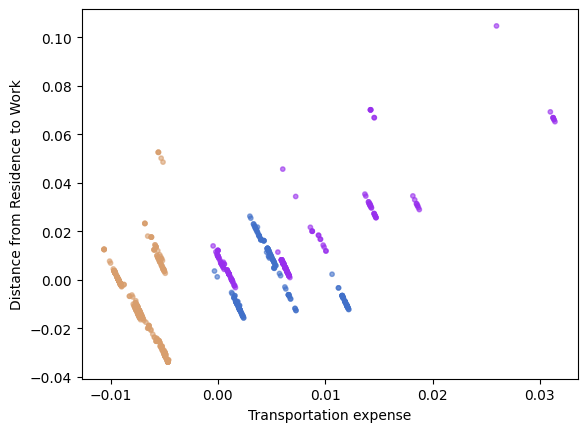

In [55]:
mpl.pyplot.scatter(dfclu1['Transportation expense'], dfclu1['Distance from Residence to Work'], c=dfclu1.c, alpha = 0.6, s=10)
mpl.pyplot.xlabel('Transportation expense')
mpl.pyplot.ylabel('Distance from Residence to Work')
mpl.pyplot.show()

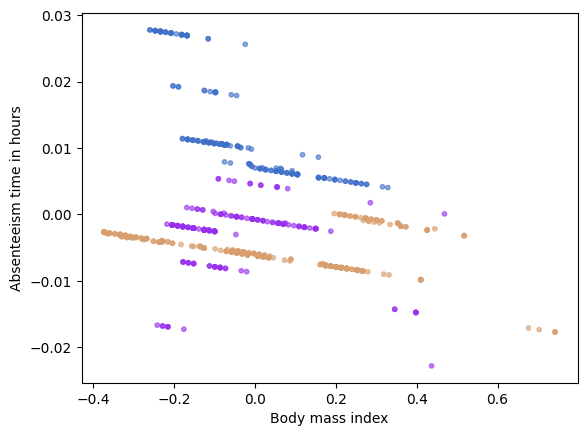

In [56]:
mpl.pyplot.scatter(dfclu1['Body mass index'], dfclu1['Absenteeism time in hours'], c=dfclu1.c, alpha = 0.6, s=10)
mpl.pyplot.xlabel('Body mass index')
mpl.pyplot.ylabel('Absenteeism time in hours')
mpl.pyplot.show()

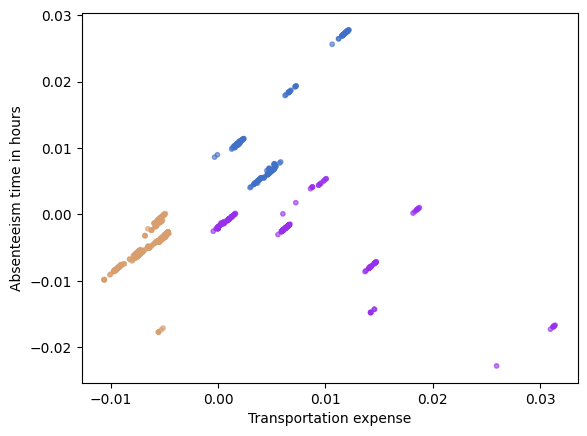

In [57]:
mpl.pyplot.scatter(dfclu1['Transportation expense'], dfclu1['Absenteeism time in hours'], c=dfclu1.c, alpha = 0.6, s=10)
mpl.pyplot.xlabel('Transportation expense')
mpl.pyplot.ylabel('Absenteeism time in hours')
mpl.pyplot.show()

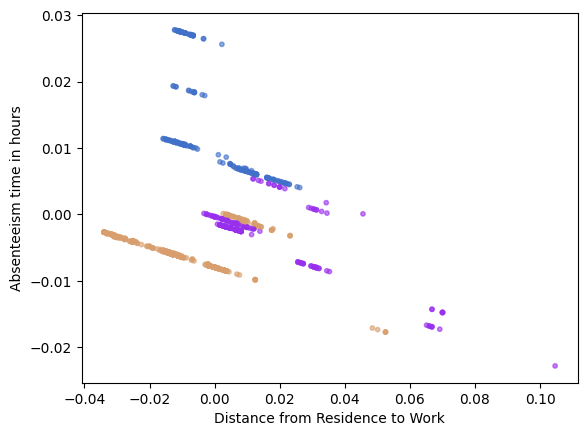

In [58]:
mpl.pyplot.scatter(dfclu1['Distance from Residence to Work'], dfclu1['Absenteeism time in hours'], c=dfclu1.c, alpha = 0.6, s=10)
mpl.pyplot.ylabel('Absenteeism time in hours')
mpl.pyplot.xlabel('Distance from Residence to Work')
mpl.pyplot.show()

Possiamo scegliere il numero ottimale di cluster prendendo il valore in cui si forma un "gomito" nel
grafico n_cluster X Within-Cluster-Sum of Squared Errors.

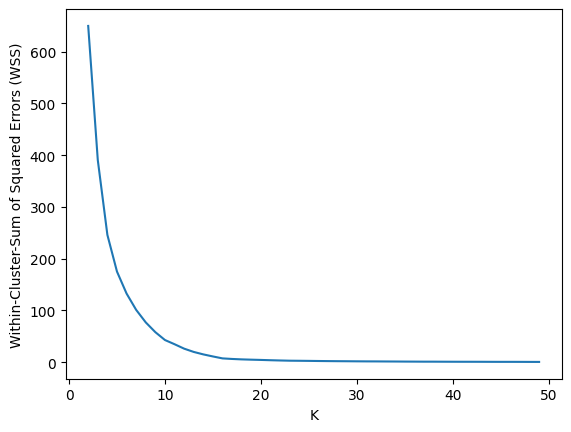

In [59]:
dfStdOD = pd.DataFrame(pcaEl.inverse_transform(dfPCA),columns=dfStd.columns)

dfclu1=dfStdOD
K=range(2,50)
wss = []

for k in K:
    kmeans1 = clu.KMeans(n_clusters=k, random_state=0)
    kmeans1= kmeans1.fit(dfclu1)
    wss_iter = kmeans1.inertia_
    wss.append(wss_iter)

mpl.pyplot.xlabel('K')
mpl.pyplot.ylabel('Within-Cluster-Sum of Squared Errors (WSS)')
mpl.pyplot.plot(K,wss)
mpl.pyplot.show()

Possiamo quindi scegliere come numero "ottimale" di cluster il numero di 10 cluster.

In [60]:
dfStdOD = pd.DataFrame(pcaEl.inverse_transform(dfPCA),columns=dfStd.columns)

dfclu1=dfStdOD

kmeans1 = clu.KMeans(n_clusters=10, random_state=0)
dfclu1['cluster'] = kmeans1.fit_predict(dfclu1)# get centroids
centroids = kmeans1.cluster_centers_
cen_x = [i[0] for i in centroids]
cen_y = [i[1] for i in centroids]
## add to df
dfclu1['cen_x'] = dfclu1.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
dfclu1['cen_y'] = dfclu1.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})# define and map colors
#colors = ['#DF2020', '#81DF20', '#2095DF','']
colors = coloration(n = kmeans1.n_clusters)
#dfclu['c'] = dfclu.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
dfclu1['c'] = dfclu1.cluster.map({0:colors[0], 1:colors[1], 2:colors[2],3:colors[3],4:colors[4], 5:colors[5], 6:colors[6],7:colors[7], 8:colors[8], 9:colors[9]});#,10:colors[10],11:colors[11], 12:colors[12], 13:colors[13],14:colors[14], 15:colors[15]})


['#EFB5AA', '#E334BA', '#31E844', '#7637D8', '#E86684', '#1F048F', '#8CB50C', '#181CD2', '#925D71', '#D385A5']


Effettuiamo di nuovo scatterplot vari:

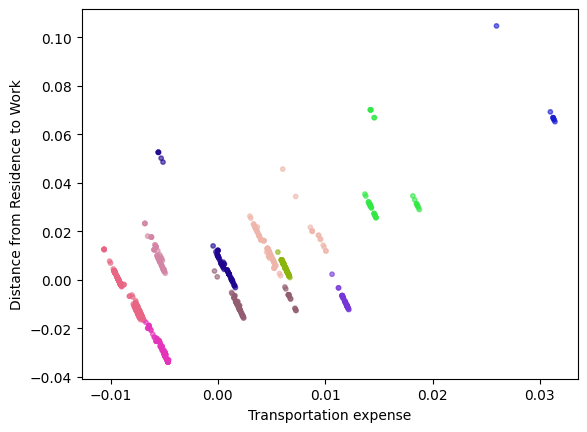

In [61]:
mpl.pyplot.scatter(dfclu1['Transportation expense'], dfclu1['Distance from Residence to Work'], c=dfclu1.c, alpha = 0.6, s=10)
mpl.pyplot.xlabel('Transportation expense')
mpl.pyplot.ylabel('Distance from Residence to Work')
mpl.pyplot.show()

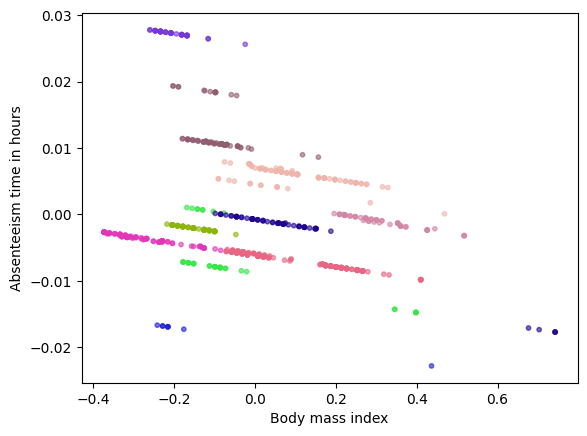

In [62]:
mpl.pyplot.scatter(dfclu1['Body mass index'], dfclu1['Absenteeism time in hours'], c=dfclu1.c, alpha = 0.6, s=10)
mpl.pyplot.xlabel('Body mass index')
mpl.pyplot.ylabel('Absenteeism time in hours')
mpl.pyplot.show()

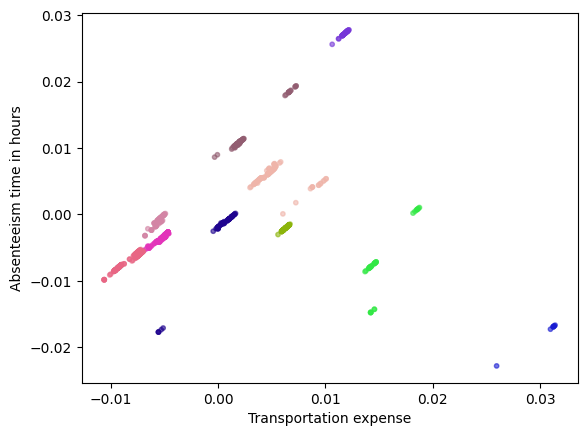

In [63]:
mpl.pyplot.scatter(dfclu1['Transportation expense'], dfclu1['Absenteeism time in hours'], c=dfclu1.c, alpha = 0.6, s=10)
mpl.pyplot.xlabel('Transportation expense')
mpl.pyplot.ylabel('Absenteeism time in hours')
mpl.pyplot.show()

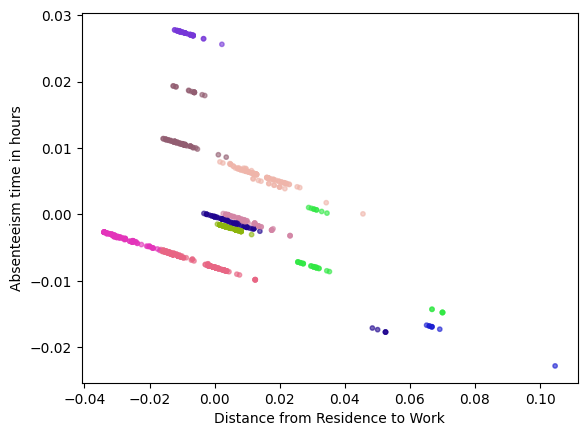

In [64]:
mpl.pyplot.scatter(dfclu1['Distance from Residence to Work'], dfclu1['Absenteeism time in hours'], c=dfclu1.c, alpha = 0.6, s=10)
mpl.pyplot.ylabel('Absenteeism time in hours')
mpl.pyplot.xlabel('Distance from Residence to Work')
mpl.pyplot.show()

Notiamo che in corrispondenza di 10 clusters notiamo una più netta e definita divisione delle classi.

Plot Centroidi. In questo caso lo mostriamo su diverse coppie di dimensioni; inoltre destandardizziamo anche il valore dei centroidi(poichè abbiamo effettuato il clustering sul dataset della PCA), in modo da vedere quali sono i valori medi dei singoli cluster negli attributi originali.

In [65]:
centroidi = pd.DataFrame(centroids,columns=dfStd.columns)*(np.diag(dfReal.cov())) + medie
centroidi

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Son,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,244.601339,32.762622,14.052823,39.438597,271.454854,93.734092,1.998651,1.157221,83.691680,171.080902,28.585355,7.942112
1,197.743908,23.377811,8.724711,29.830095,272.865024,96.511014,0.000520,0.011587,65.962341,174.397167,21.472615,6.289506
2,289.481152,37.578148,7.389779,32.351714,271.951863,94.549631,1.209046,4.172148,75.794764,170.370790,25.953902,5.670934
3,274.257812,27.712928,11.858965,36.248648,275.330206,95.118519,4.000404,0.020815,69.308160,173.140952,22.971259,11.766065
4,182.953021,28.594515,14.999470,38.742794,269.746931,94.147388,-0.000038,-0.001610,85.410630,171.998185,28.970012,5.639917
5,222.276407,31.461441,13.423894,37.937289,270.750153,94.078904,0.927958,1.065734,83.108094,171.433247,28.291096,6.507940
6,249.449075,30.725237,8.522296,31.864958,272.631655,95.384540,0.998393,2.005509,71.360508,172.295083,23.906463,6.555476
7,358.452806,45.346044,0.683072,26.198171,272.543430,94.906602,1.005406,7.957676,69.769563,168.832942,24.190713,3.789900
8,234.147709,27.431116,12.645904,36.444109,273.168745,94.943203,2.209454,-0.033368,74.424565,172.915471,24.843297,9.114924
9,196.349219,31.806774,18.285362,43.913404,269.108429,92.848824,0.997647,0.009183,94.058861,170.712493,32.358118,6.738700


Notiamo che i valori dei centroidi, che dovrebbero essere i valori medi i ogni cluster, variano soprattutto in termini degli attributi "Transportation expense","Distance from Residence to Work", "Service time", "Age", "Son", "Pet", "Weight", "Body mass index", "Absenteeism time in hours": questi attributi possono determinare una certa caratterizzazione dei lavoratori da cui sono stati presi i dati, in funzione della loro lontananza dal posto di lavoro e delle loro caratteristiche fisiche e familiari, che possono effettivamente avere anche effetto sul tempo d'assenteismo.

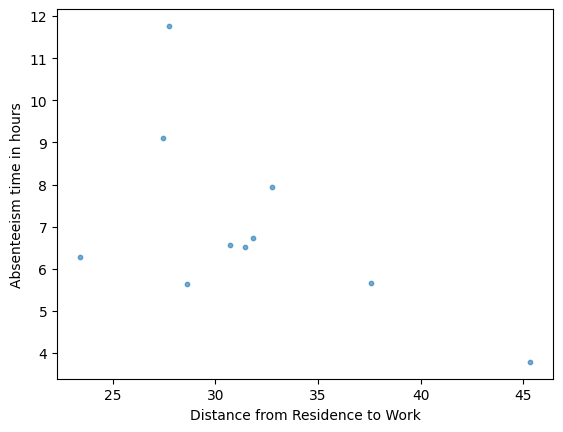

In [66]:
mpl.pyplot.scatter(centroidi['Distance from Residence to Work'], centroidi['Absenteeism time in hours'], alpha = 0.6, s=10)
mpl.pyplot.ylabel('Absenteeism time in hours')
mpl.pyplot.xlabel('Distance from Residence to Work')
mpl.pyplot.show()

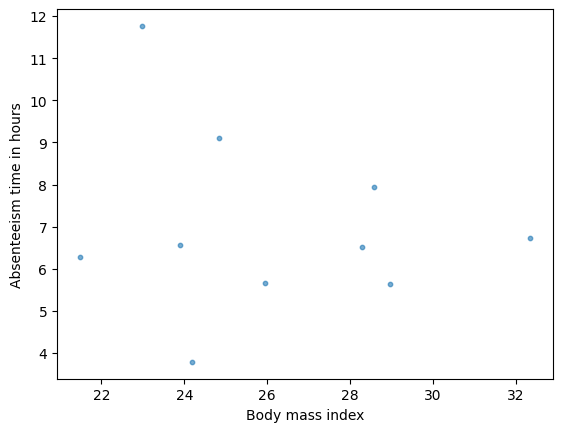

In [67]:
mpl.pyplot.scatter(centroidi['Body mass index'], centroidi['Absenteeism time in hours'],  alpha = 0.6, s=10)
mpl.pyplot.xlabel('Body mass index')
mpl.pyplot.ylabel('Absenteeism time in hours')
mpl.pyplot.show()

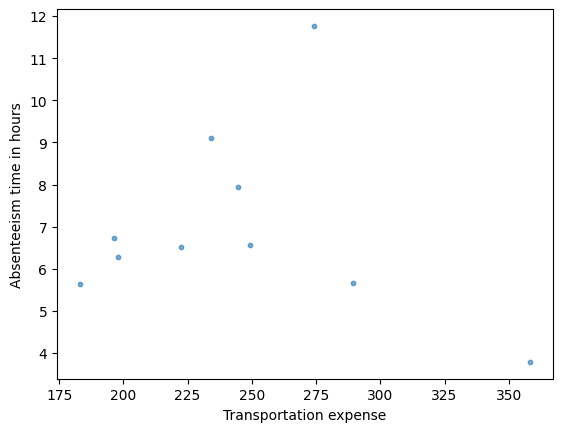

In [68]:
mpl.pyplot.scatter(centroidi['Transportation expense'], centroidi['Absenteeism time in hours'],  alpha = 0.6, s=10)
mpl.pyplot.xlabel('Transportation expense')
mpl.pyplot.ylabel('Absenteeism time in hours')
mpl.pyplot.show()

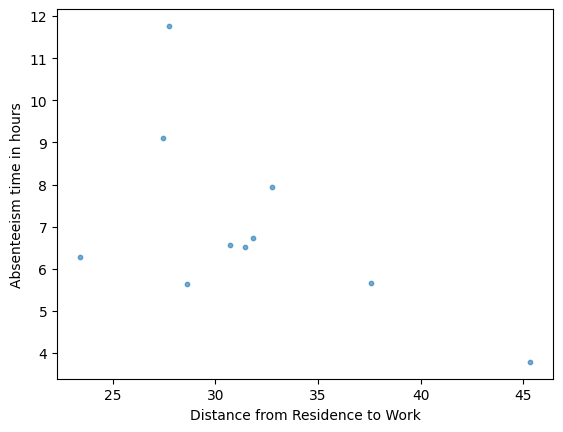

In [69]:
mpl.pyplot.scatter(centroidi['Distance from Residence to Work'], centroidi['Absenteeism time in hours'],  alpha = 0.6, s=10)
mpl.pyplot.ylabel('Absenteeism time in hours')
mpl.pyplot.xlabel('Distance from Residence to Work')
mpl.pyplot.show()

Ora proviamo ad applicare il clustering alle componenti principali precedentemente trovate.

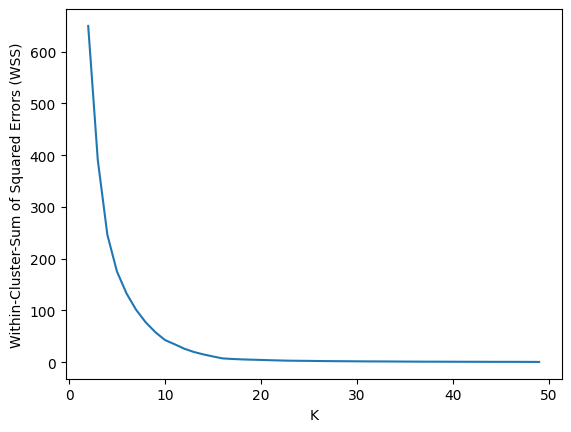

In [70]:



dfclu2=dfPCA
K=range(2,50)
wss = []

for k in K:
    kmeans2 = clu.KMeans(n_clusters=k, random_state=0)
    kmeans2= kmeans2.fit(dfclu2)
    wss_iter = kmeans2.inertia_
    wss.append(wss_iter)

mpl.pyplot.xlabel('K')
mpl.pyplot.ylabel('Within-Cluster-Sum of Squared Errors (WSS)')
mpl.pyplot.plot(K,wss)

mpl.pyplot.show()

Anche sul dataset proiettato sulla PCA otteniamo un gomito in corrispondenza di 10 clusters.

['#5FF56E', '#50B885', '#E9030A', '#D6109C', '#04609D', '#DA5ECF', '#5BE6C7', '#9F304A', '#95712D', '#B8833B']


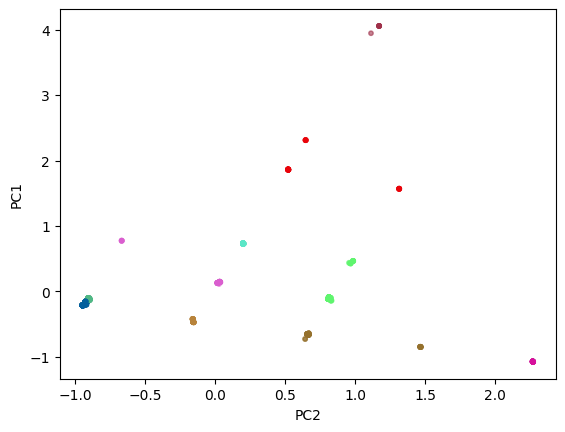

In [71]:

dfclu2 = pd.DataFrame(data=pcaEl.transform(dfStd),columns=['PC1','PC2','PC3'])
kmeans2=clu.KMeans(n_clusters=10,random_state=0)
dfclu2['cluster'] = kmeans2.fit_predict(dfclu2)
centroids = kmeans2.cluster_centers_
cen_x = [i[0] for i in centroids]
cen_y = [i[1] for i in centroids]
## add to df
dfclu2['cen_x'] = dfclu2.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
dfclu2['cen_y'] = dfclu2.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})# define and map colors

colors = coloration(n = kmeans2.n_clusters)
dfclu2['c'] = dfclu2.cluster.map({0:colors[0], 1:colors[1], 2:colors[2],3:colors[3],4:colors[4],5:colors[5],6:colors[6],7:colors[7],8:colors[8],9:colors[9]})

mpl.pyplot.scatter(dfclu2['PC1'], dfclu2['PC2'], c=dfclu2.c, alpha = 0.6, s=10)
mpl.pyplot.ylabel('PC1')
mpl.pyplot.xlabel('PC2')
mpl.pyplot.show()

Riproiettando all'indietro il dataset con i nuovi cluster si ottiene:

In [72]:
dfStdOD = pd.DataFrame(pcaEl.inverse_transform(dfPCA),columns=dfStd.columns)

dfclu2rip = dfStdOD.join(other=[dfclu2['cen_x'],dfclu2['cen_y'],dfclu2['c'],dfclu2['cluster']])



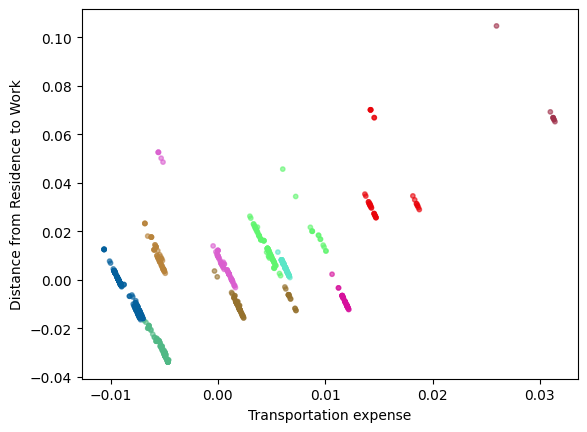

In [73]:
mpl.pyplot.scatter(dfclu2rip['Transportation expense'], dfclu2rip['Distance from Residence to Work'], c=dfclu2rip.c, alpha = 0.6, s=10)
mpl.pyplot.xlabel('Transportation expense')
mpl.pyplot.ylabel('Distance from Residence to Work')
mpl.pyplot.show()

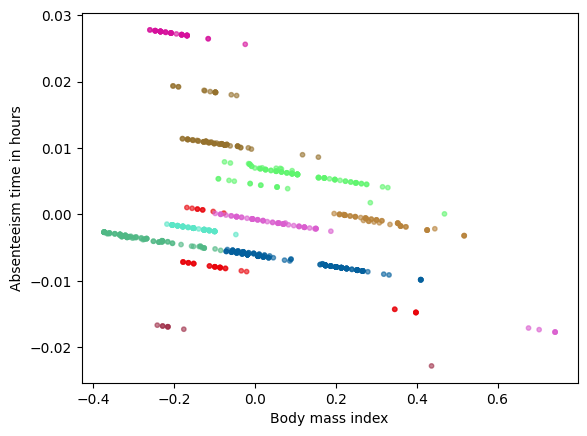

In [74]:
mpl.pyplot.scatter(dfclu2rip['Body mass index'], dfclu2rip['Absenteeism time in hours'], c=dfclu2rip.c, alpha = 0.6, s=10)
mpl.pyplot.xlabel('Body mass index')
mpl.pyplot.ylabel('Absenteeism time in hours')
mpl.pyplot.show()

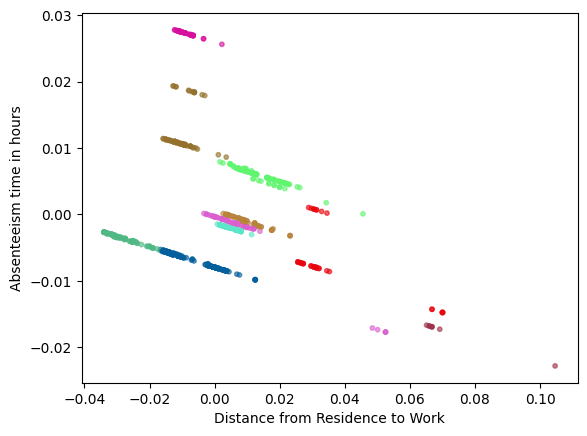

In [75]:
mpl.pyplot.scatter(dfclu2rip['Distance from Residence to Work'], dfclu2rip['Absenteeism time in hours'], c=dfclu2rip.c, alpha = 0.6, s=10)
mpl.pyplot.ylabel('Absenteeism time in hours')
mpl.pyplot.xlabel('Distance from Residence to Work')
mpl.pyplot.show()

Anche in questo caso i clusters sono distribuiti nella stessa maniera del caso precedente.

Nella seguente sezione ci andremo ad occupare dell'altra tipologia di algoritmi di clusering, cioè quelli gerarchici.

HIERARCHICAL AGGLOMERATIVE CLUSTERTING

Questo tipo di clustering, a differenza del K-means, non si basa sul minimizzare l'errore fra tutti i punti interni dei clusters, esso utilizza un approccio gerarchico: infatti partendo dai singoli punti, che saranno considerati dei "cluster" iniziali, si formeranno dei nuovi cluster sempre più grandi: infatti, mano a mano che l'algoritmo lavora, vengono creati sempre nuovi cluster dai cluster precedenti, accorpando i cluster stessi e quindi unendo di volta in volta i due più vicini, ottenendo così cluster di dimensione maggiore; l'algoritmo finisce quando tutti i punti saranno contenuti in un unico cluster. Possiamo notare che, a differenza del K-means, non si sceglie il numero di cluster all'inizio dell'algoritmo, ma si parte dal creare prima i cluster dai singoli punti, scegliendo poi in seguito il numero più soddisfacente(nella function utilizzata può essere passato come parametro, ma all'inizio del run dell'algoritmo i cluster non esistono, non essendo scelti i centroidi come nel K-means). La cosa che può variare è il criterio scelto per calcolare le distanze fra cluster(Completo, Singolo,Medio e con i centroidi), scegliendo poi una misura di dissimilarità per effettuare il calcolo vero e proprio. Nel nostro caso abbiamo utilizzato una distanza euclidea per misurare le distanze fra punti(i dati sono tutti reali e standardizzati) con un linkage di tipo Average(la media delle distanze fra gli elementi di un cluster e quelli dell'altro).

['#1F7D85', '#531C18']


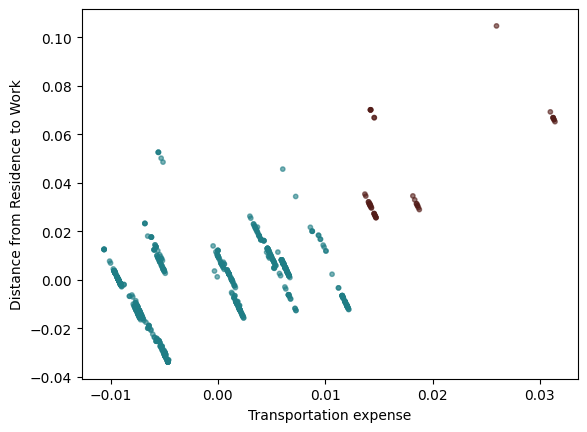

In [76]:
dfStdOD = pd.DataFrame(pcaEl.inverse_transform(dfPCA),columns=dfStd.columns)

dfclu3=dfStdOD


hierarchy1 = clu.AgglomerativeClustering(n_clusters=2, affinity='euclidean',linkage='average')

dfclu3['cluster'] = hierarchy1.fit_predict(dfclu3)

colors = coloration(n = hierarchy1.n_clusters)
dfclu3['c'] = dfclu3.cluster.map({0:colors[0], 1:colors[1]})
mpl.pyplot.scatter(dfclu3['Transportation expense'], dfclu3['Distance from Residence to Work'], c=dfclu3.c, alpha = 0.6, s=10)
mpl.pyplot.xlabel('Transportation expense')
mpl.pyplot.ylabel('Distance from Residence to Work')
mpl.pyplot.show()

Il dendrogramma è un grafico che ci permette di visualizzare l'ordine dei join che sono avvenuti tra ogni cluster per formare quelli più grandi e la distanza fra di essi. Con esso noi possiamo scegliere il numero di cluster soddisfacente, scegliendo il livello desiderato di distanza fra i cluster interni.

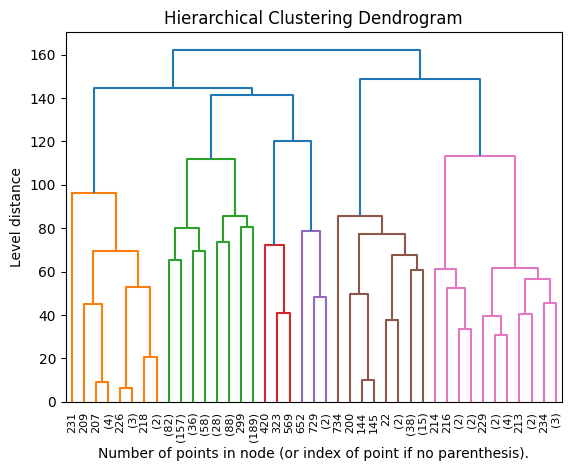

In [77]:

#dendogram
df = pd.read_csv(r'D:\Users\Giuseppe Biagio\Desktop\POLITECNICO\Ingegneria Matematica\Apprendimento Statistico\Tesina ML Giuseppe Biagio Lapadula\Absenteeism_at_work_AAA\Absenteeism_at_work1.CSV',
                 sep=';',header=0,names=['ID','Reason for absence','Month of absence','Day of the week','Seasons','Transportation expense','Distance from Residence to Work','Service time','Age',
                                         'Work load Average/day','Hit target','Disciplinary failure','Education','Son','Social drinker','Social smoker','Pet','Weight','Height','Body mass index',
                                         'Absenteeism time in hours'])
#qui non decidiamo a priori il numero di clusters
hierarchy1 = clu.AgglomerativeClustering(n_clusters=None,distance_threshold=0,affinity='euclidean',linkage='average')
hierarchy1 = hierarchy1.fit(df)
def plot_dendrogram(model, **kwargs):
    import numpy as np
    from scipy.cluster.hierarchy import dendrogram

    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

mpl.pyplot.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(hierarchy1, truncate_mode='level',p=5)
mpl.pyplot.xlabel("Number of points in node (or index of point if no parenthesis).")
mpl.pyplot.ylabel('Level distance')
mpl.pyplot.show()



Noi abbiamo deciso di fermarci al livello 120, che conterrà 5 cluster. In seguito mostreremo alcuni plot risultanti.

In [78]:
dfStdOD = pd.DataFrame(pcaEl.inverse_transform(dfPCA),columns=dfStd.columns)

dfclu3=dfStdOD


hierarchy1 = clu.AgglomerativeClustering(n_clusters=5, affinity='euclidean',linkage='average')

dfclu3['cluster'] = hierarchy1.fit_predict(dfclu3)

colors = coloration(n = hierarchy1.n_clusters)
dfclu3['c'] = dfclu3.cluster.map({0:colors[0], 1:colors[1],2:colors[2], 3:colors[3],4:colors[4]})

#provare a mettere 10 cluster e questa mappa di colori
#dfclu3['c'] = dfclu3.cluster.map({0:colors[0], 1:colors[1], 2:colors[2],3:colors[3],4:colors[4],5:colors[5],6:colors[6],7:colors[7],8:colors[8],9:colors[9]})


['#FCDB7D', '#778FA4', '#31C0ED', '#475685', '#B2DEEC']


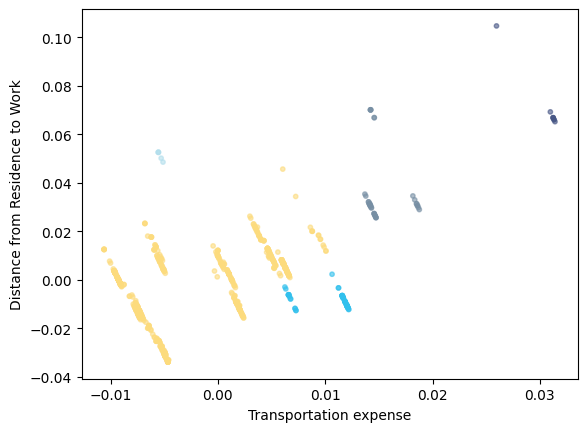

In [79]:
mpl.pyplot.scatter(dfclu3['Transportation expense'], dfclu3['Distance from Residence to Work'], c=dfclu3.c, alpha = 0.6, s=10)
mpl.pyplot.xlabel('Transportation expense')
mpl.pyplot.ylabel('Distance from Residence to Work')
mpl.pyplot.show()

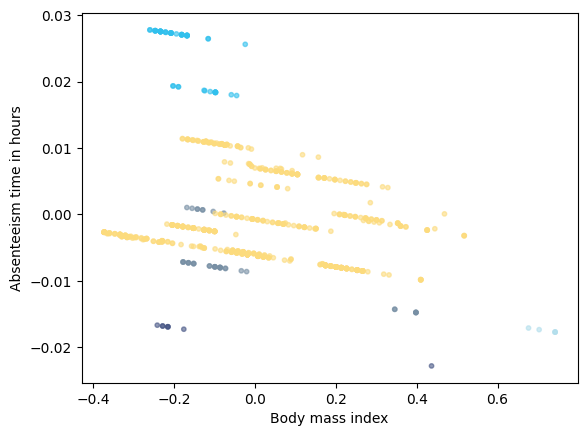

In [80]:
mpl.pyplot.scatter(dfclu3['Body mass index'], dfclu3['Absenteeism time in hours'], c=dfclu3.c, alpha = 0.6, s=10)
mpl.pyplot.xlabel('Body mass index')
mpl.pyplot.ylabel('Absenteeism time in hours')
mpl.pyplot.show()

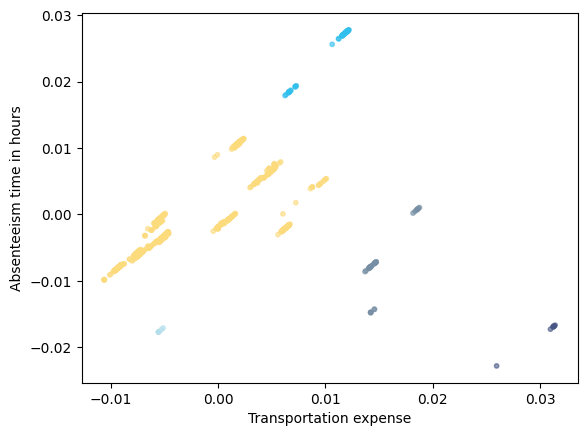

In [81]:
mpl.pyplot.scatter(dfclu3['Transportation expense'], dfclu3['Absenteeism time in hours'], c=dfclu3.c, alpha = 0.6, s=10)
mpl.pyplot.xlabel('Transportation expense')
mpl.pyplot.ylabel('Absenteeism time in hours')
mpl.pyplot.show()

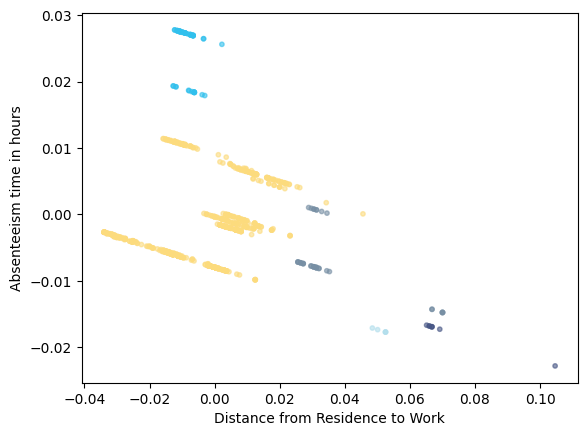

In [82]:
mpl.pyplot.scatter(dfclu3['Distance from Residence to Work'], dfclu3['Absenteeism time in hours'], c=dfclu3.c, alpha = 0.6, s=10)
mpl.pyplot.ylabel('Absenteeism time in hours')
mpl.pyplot.xlabel('Distance from Residence to Work')
mpl.pyplot.show()

CLASSIFICATION

Dopo aver applicato gli algoritmi unsupervised, vogliamo invece ora testare gli algoritmi di supervised learning, per provare a predirre un attributo. In questo caso, l'attributo in questione sarà creato ad hoc: il nostro obbiettivo qui è discretizzare l'attributo "Absenteeism time in hours" in 3 categorie, splittate in base alla posizione dei valori di questa feature rispetto al primo e al terzo quartile dell'intero dataset. Quindi abbiamo eliminato dal dataset l'attributo reale, lasciando quello discreto chiamato "Quartile Hours". Gli altri attributi invece verranno destandardizzati, riportandoli alla scala e allo shift iniziali.

In [83]:
dfPCA = pcaEl.transform(dfStd)


dfStdOD = pd.DataFrame(pcaEl.inverse_transform(dfPCA),columns=dfStd.columns)*(np.diag(dfReal.cov())) + medie

#dfpred1=pd.DataFrame(pcaEl.inverse_transform(dfPCA),columns=dfStd.columns)
dfpred1 = dfStdOD.drop(columns ='Absenteeism time in hours')
dfresp1 = dfStdOD['Absenteeism time in hours']
temp1 = dfresp1.values > np.quantile(dfresp1.values,0.25)
temp1 = booltoint(temp1)
temp2 = dfresp1.values > np.quantile(dfresp1.values,0.75)
temp2 = booltoint(temp2)
dfresp1 = pd.DataFrame( temp1+temp2 , columns=['Quartile Hours'])
dfresp1['Quartile Hours'] = dfresp1['Quartile Hours'].astype('int')
dfresp1['Quartile Hours'] = dfresp1['Quartile Hours'].astype('category')
dfpred1['Quartile Hours'] = dfresp1.values
dfpred1['Quartile Hours'] = dfpred1['Quartile Hours'].astype('category')

dfpred1

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Son,Pet,Weight,Height,Body mass index,Quartile Hours
0,243.987656,31.569749,13.264095,38.175909,271.938215,94.118223,1.989539,1.009108,80.688626,171.545525,27.404551,2
1,198.181065,30.745216,17.215689,42.350431,269.675175,93.279759,1.000205,-0.037232,90.553260,171.174386,30.999465,1
2,179.956047,29.536954,16.176528,40.404001,269.164987,93.709809,-0.003689,-0.013820,89.027309,171.558798,30.362603,0
3,230.332513,27.283426,12.514838,36.169310,273.016154,94.995298,2.002491,-0.019656,74.402409,172.953066,24.826106,2
4,243.984959,31.570541,13.264698,38.176790,271.937717,94.117947,1.989407,1.009204,80.691077,171.545190,27.405504,2
...,...,...,...,...,...,...,...,...,...,...,...,...
735,242.451129,32.277648,14.048258,39.305649,271.542104,93.813820,1.993263,1.022729,83.171442,171.229066,28.364192,2
736,221.257949,31.803963,14.072841,38.835006,270.541823,93.867647,0.998684,1.000730,84.762155,171.253671,28.922776,1
737,337.703704,52.661751,9.468336,38.678053,268.170396,91.595298,0.999867,7.943078,97.021522,165.469965,34.696799,0
738,253.829267,37.179864,15.656237,42.509938,270.065412,92.629338,1.988937,2.021135,91.995960,169.524200,31.917295,1


Premessa tecnica: avendo un dataset relativamente piccolo, per poter effettuare training e testing dei modelli abbiamo deciso di utilizzare un approccio Cross Validation, splittando il dataset utilizzando l'algoritmo K-fold. Inoltre, essendo le classi dell'attributo discreto diversamente dense, abbiamo deciso di utilizzare un approccio di campionamento stratificato, cioè all'interno dei folds ottenuti dal K-folds i dati rispettano la stessa densità di composizione delle classi che si riscontra sull'intero dataset.

RANDOM FOREST

Il primo algoritmo che andremo a testare è la random forest. Questo algoritmo in realtà è un algoritmo di ensemble, cioè un modello dato dall'utilizzo di sotto modelli più semplici e meno performanti(nel nostro caso ci riferiamo agli alberi decisionali).

Un albero decisionale è un modello di classificazione strutturato, come dice il nome, ad "albero": l'idea è quella di dividere un dataset X in regioni, in base alle quali si va a fittare una funzione di predizione semplice: ad esempio, il modello può scegliere per maggioranza la classe predetta, in base alle regioni generate sul nostro spazio delle variabili X. Le regioni possono essere ricavate splittando secondo condizioni logiche sui dati. I nodi vengono creati generando più split da un nodo padre, che a sua volta genererà altri nodi (sotto regioni) che potranno essere ulteriormente splittate, formando la struttura ad albero (l'approccio utilizzato è top down, perchè si parte dall'intero dataset prima del nodo padre fino ad arrivare alle regioni finali, corrispondenti alle foglie).Gli split sono binari e avvengono secondo la minimizzazione dell'errore di classificazione, che alternativamente può essere utilizzare le misure di impurità(ciò che fa l'algoritmo), come misclassification impurity, entropy impurity o Gini impurity; lo split avviene se la riduzione dell'errore è effettivamente significativa rispetto al caso in cui la regione non viene splittata. Possiamo modificare alcuni iperparametri, come la massima profondità dell'albero(noi abbiamo scelto di far variare questo) o il massimo numero di split, utili come criterio di fine della generazione di split nell'albero, per prevenire l'overfitting.

La Random forest è un modello bagging di decision tree: l'idea è quella di generare più alberi decisionali,ognuno allenato e testato su una copia del nostro dataset e utilizzando un sottoinsieme di features diverse per ogni albero. Dalle predizioni ottenute da ogni albero, si ottiene la classificazione totale della RF secondo un criterio di maggioranza.

Plot di performances in accuratezza bilanciata media e tempo medio di fitting, al variare dell'iperparametro "Numero di alberi"

In [84]:
scores = np.zeros([4,1])
time = np.zeros([4,1])
nprove = 10

for i in range(nprove):

    rfN0 = ens.RandomForestClassifier(n_estimators=1)
    CVrfN0 = ms.cross_validate(rfN0,dfpred1,dfresp1.values,scoring='balanced_accuracy')
    scores[0] = scores[0] + np.mean(CVrfN0['test_score'])
    time[0] = time[0] + np.mean(CVrfN0['fit_time'])

    rfN1 = ens.RandomForestClassifier(n_estimators=5)
    CVrfN1 = ms.cross_validate(rfN1,dfpred1,dfresp1,scoring='balanced_accuracy')
    scores[1] = scores[1] + np.mean(CVrfN1['test_score'])
    time[1] = time[1] + np.mean(CVrfN1['fit_time'])

    rfN2 = ens.RandomForestClassifier(n_estimators=10)
    CVrfN2 = ms.cross_validate(rfN2,dfpred1,dfresp1,scoring='balanced_accuracy')
    scores[2] = scores[2] + np.mean(CVrfN2['test_score'])
    time[2] = time[2] + np.mean(CVrfN2['fit_time'])

    rfN3 = ens.RandomForestClassifier(n_estimators=20)
    CVrfN3 = ms.cross_validate(rfN3,dfpred1,dfresp1,scoring='balanced_accuracy')
    scores[3] = scores[3] + np.mean(CVrfN3['test_score'])
    time[3] = time[3] + np.mean(CVrfN3['fit_time'])

scores = scores/nprove
time = time/nprove

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBia

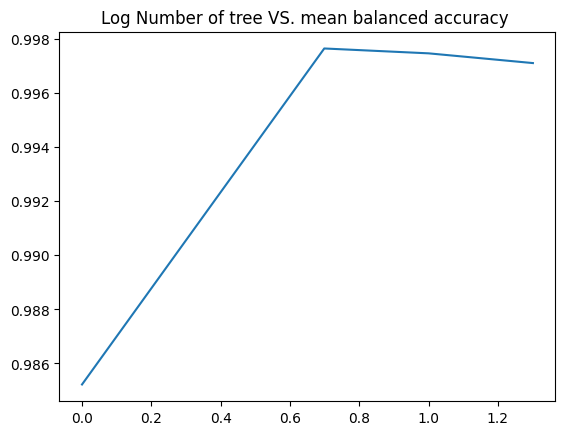

In [85]:
mpl.pyplot.plot(np.log10([1,5,10,20]),scores)
mpl.pyplot.title('Log Number of tree VS. mean balanced accuracy ')
mpl.pyplot.show()

Quello che possiamo notare è che l'accuratezza media in questo caso è relativamente la stessa al variare del numero di alberi, anche se aumenta leggermente all'aumentare degli alberi utilizzati. Ciò quindi è in accordo con la teoria, dove appunto l'accuratezza di una random forest banale(cioè con un solo albero decisionale), che è il primo valore nel grafico, è inferiore a quella di una random forest con più alberi.

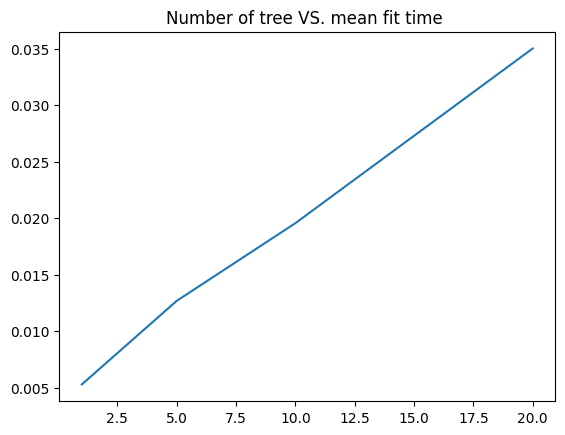

In [86]:
mpl.pyplot.plot([1,5,10,20],time)
mpl.pyplot.title('Number of tree VS. mean fit time ')
mpl.pyplot.show()

Possiamo notare che fittare random forest con più alberi è molto più costoso in termini di tempo, dato che si fittano più modelli.

Plot di performances in accuratezza bilanciata media e tempo medio di fitting, al variare dell'iperparametro "Massima profondità alberi"

In [87]:
scores = np.zeros([4,1])
time = np.zeros([4,1])
nprove = 20

for i in range(nprove):

    rfD0 = ens.RandomForestClassifier(max_depth=5)
    CVrfD0 = ms.cross_validate(rfD0,dfpred1,dfresp1,scoring='balanced_accuracy')
    scores[0] = scores[0] + np.mean(CVrfD0['test_score'])
    time[0] = time[0] + np.mean(CVrfD0['fit_time'])


    rfD1 = ens.RandomForestClassifier(max_depth=10)
    CVrfD1 = ms.cross_validate(rfD1,dfpred1,dfresp1,scoring='balanced_accuracy')
    scores[1] = scores[1] + np.mean(CVrfD1['test_score'])
    time[1] = time[1] + np.mean(CVrfD1['fit_time'])


    rfD2 = ens.RandomForestClassifier(max_depth=20)
    CVrfD2 = ms.cross_validate(rfD2,dfpred1,dfresp1,scoring='balanced_accuracy')
    scores[2] = scores[2] + np.mean(CVrfD2['test_score'])
    time[2] = time[2] + np.mean(CVrfD2['fit_time'])


    rfD3 = ens.RandomForestClassifier(max_depth=50)
    CVrfD3 = ms.cross_validate(rfD3,dfpred1,dfresp1,scoring='balanced_accuracy')
    scores[3] = scores[3] + np.mean(CVrfD3['test_score'])
    time[3] = time[3] + np.mean(CVrfD3['fit_time'])

scores = scores/nprove
time = time/nprove


d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBia

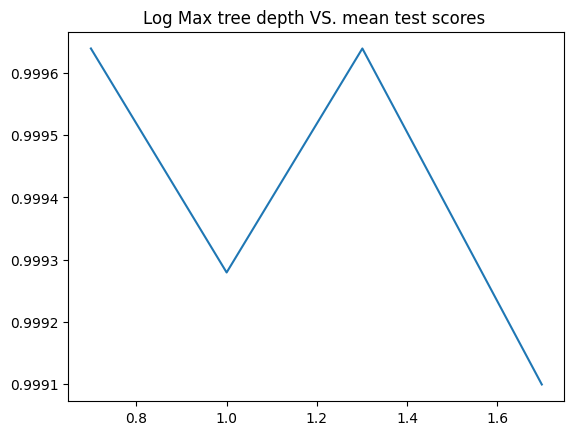

In [88]:

mpl.pyplot.plot(np.log10([5,10,20,50]),scores)
mpl.pyplot.title('Log Max tree depth VS. mean test scores ')
mpl.pyplot.show()

Nota: i risultati tendono a variare leggermente nelle diverse esecuzioni.
Per quanto riguarda l'accuratezza, essa rimane più o meno attorno agli stessi valori, anche se tende a scendere (leggermente in questo caso) quando aumentano troppo i livelli. Ciò è dovuto al fenomeno dell'overfitting, a cui gli alberi sono molto soggetti.

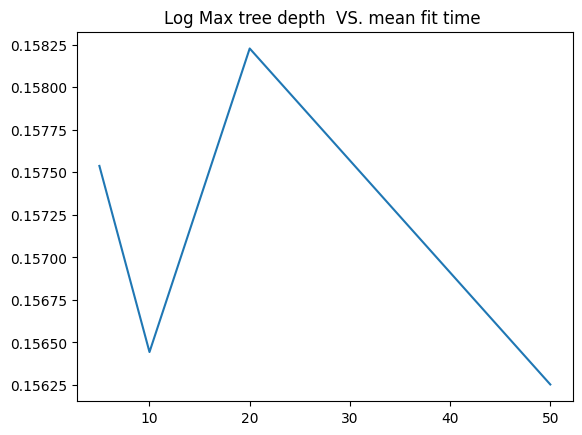

In [89]:

mpl.pyplot.plot([5,10,20,50],time)
mpl.pyplot.title('Log Max tree depth  VS. mean fit time ')
mpl.pyplot.show()

Il tempo di fitting rimane pressochè invariato, o comunque varia leggermente, poichè questa volta il numero di modelli è lo stesso in ogni caso esplorato e gli split con queste profondità non risultano essere troppo costosi.

Ora vogliamo valutare le performance della random forest sul nostro dataset, usando un approccio di cross validation e campionamento stratificato. Verranno quindi plottate delle matrici di confusione, curve ROC e gli indicatori di performance per la classificazione, cioè Accuracy, Recall, Specificity e AUC.

C:\Users\Giuseppe Biagio\AppData\Local\Temp\ipykernel_11408\1335465921.py:146: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\Giuseppe Biagio\AppData\Local\Temp\ipykernel_11408\1335465921.py:146: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\Giuseppe Biagio\AppData\Local\Temp\ipykernel_11408\1335465921.py:146: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\Giuseppe Biagio\AppData\Local\Temp\ipykernel_11408\1335465921.py:146: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\Giuseppe Biagio\AppData\Local\Temp\ipykernel_11

Confusion matrix, without normalization


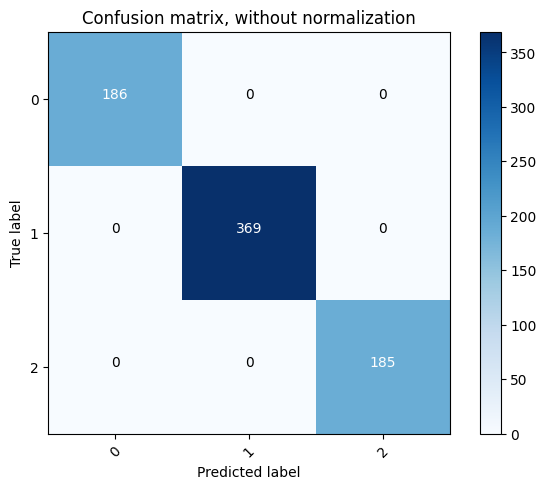

Normalized confusion matrix


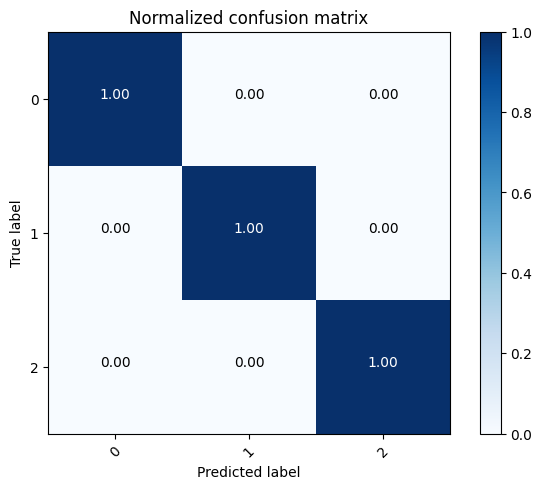

In [90]:
data = dfpred1
target = dfresp1


class_names = ['0','1','2']

labels, counts = np.unique(target, return_counts=True)

# labels, counts = np.unique(target, return_counts=True)


predicted_target, actual_target = evaluate_modelRF(data, target, n_folds=10, n_estimators=20, max_depth=10)
plot_confusion_matrix(predicted_target, actual_target,class_names )

mpl.pyplot.show()

accuracy =  1.0
 precision =  [1. 1. 1.]
 recall =  [1. 1. 1.]
 specificity =  [[1. 1. 1.]]
 AUC =  [[1. 1. 1.]]


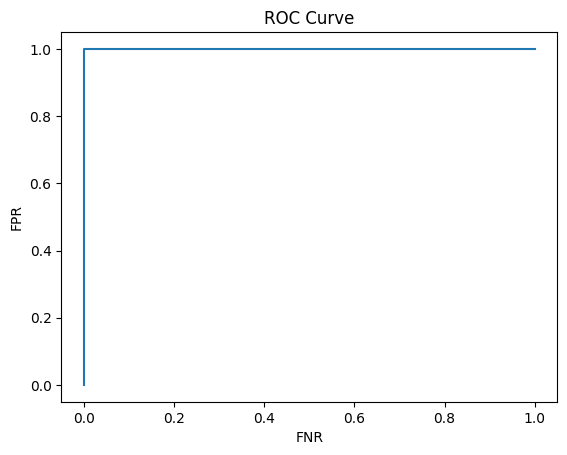

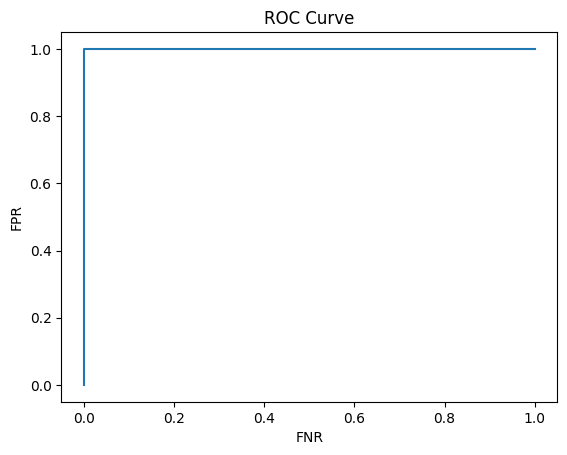

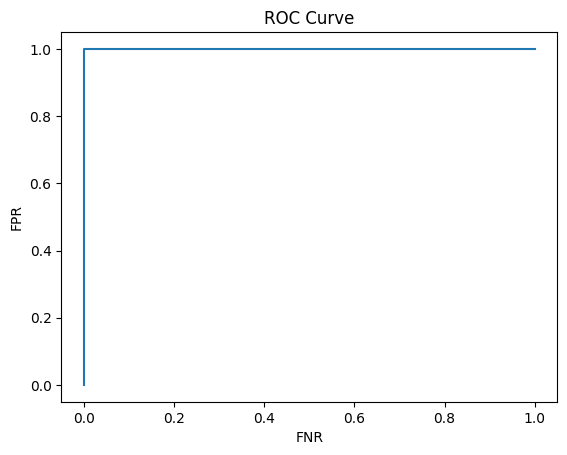

In [91]:

accuracy,precision,recall,specificity,AUC = generate_class_metrix(predicted_target, actual_target,n_classes=3)
print("accuracy = ",accuracy)
print (" precision = ",precision)
print(" recall = ",recall)
print(" specificity = ", specificity.T)
print(" AUC = ",AUC.T)
mpl.pyplot.show()

Quello che possiamo dire è che, date le performances mostrate, la random forest in questo caso classifica molto bene le etichette dei testing folds nella cross validation(praticamente in maniera perfetta).

K-Nearest Neighbour

Il K-NN è un modello di classificazione basato sulle distanze: supponendo di dover classificare il dato X, che avrà p features, prendiamo un sottoinsieme di k record dal training set tali che essi siano i k records più vicini al nostro X; la classificazione avviene scegliendo la classe che nei k vicini ha più occorrenze e, nel caso ci fossero delle classi che hanno tutte la proporzione di dati massima e uguale fra di esse, l'algoritmo sceglie casualmente la classe secondo una distribuzione uniforme sulle suddette classi.

Plot di performances in accuratezza bilanciata media e tempo medio di fitting, al variare dell'iperparametro "Numero di vicini"

In [92]:
scores = np.zeros([4,1])
time = np.zeros([4,1])
nprove = 10

for i in range(nprove):

    knnk0 = neig.KNeighborsClassifier(n_neighbors=5)
    CVknnk0 = ms.cross_validate(knnk0,dfpred1,dfresp1,scoring='balanced_accuracy')
    scores[0] = scores[0] + np.mean(CVknnk0['test_score'])
    time[0] = time[0] + np.mean(CVknnk0['fit_time'])

    knnk1 =neig.KNeighborsClassifier(n_neighbors=10)
    CVknnk1 = ms.cross_validate(knnk1,dfpred1,dfresp1,scoring='balanced_accuracy')
    scores[1] = scores[1] + np.mean(CVknnk1['test_score'])
    time[1] = time[1] + np.mean(CVknnk1['fit_time'])

    knnk2 = neig.KNeighborsClassifier(n_neighbors=20)
    CVknnk2 = ms.cross_validate(knnk2,dfpred1,dfresp1,scoring='balanced_accuracy')
    scores[2] = scores[2] + np.mean(CVknnk2['test_score'])
    time[2] = time[2] + np.mean(CVknnk2['fit_time'])

    knnk3 = neig.KNeighborsClassifier(n_neighbors=50)
    CVknnk3 = ms.cross_validate(knnk3,dfpred1,dfresp1,scoring='balanced_accuracy')
    scores[3] = scores[3] + np.mean(CVknnk3['test_score'])
    time[3] = time[3] + np.mean(CVknnk3['fit_time'])


scores = scores/nprove
time = time/nprove


d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_La

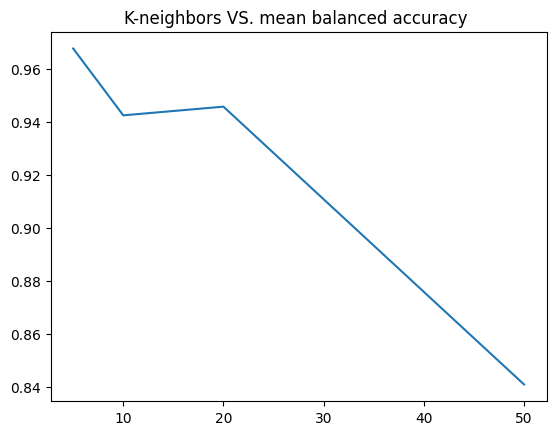

In [93]:

mpl.pyplot.plot([5,10,20,50],scores)
mpl.pyplot.title('K-neighbors VS. mean balanced accuracy ')
mpl.pyplot.show()

Possiamo notare già subito che in generale l'accuratezza bilanciata è minore rispetto a quella ottenuta con le random forest. Inoltre, all'aumentare del numero di vicini considerati, essa tende a decrescere.

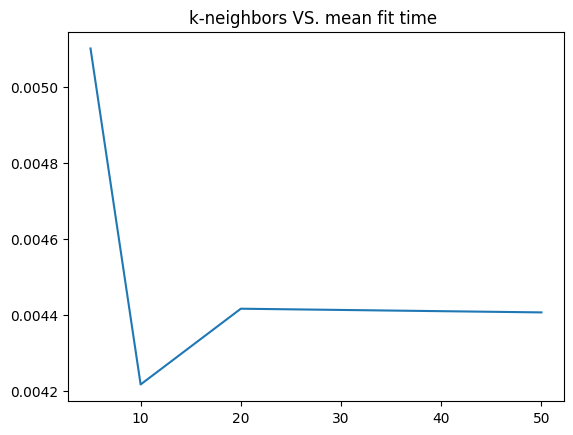

In [94]:

mpl.pyplot.plot([5,10,20,50],time)
mpl.pyplot.title('k-neighbors VS. mean fit time ')
mpl.pyplot.show()


Qui si nota subito che i tempi d'esecuzione dell'algoritmo KNN sono due ordini di grandezza inferiori rispetto alla random forest, ed in questo caso tendono a diminuire all'aumentare del numero di nodi vicini considerati nella classificazione di ogni nodo.

Come fatto nel caso precedente, ora si procederà a valutare le performances del K-NN calcolando e plottando tutti gli indicatori necessari.

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_La

Confusion matrix, without normalization


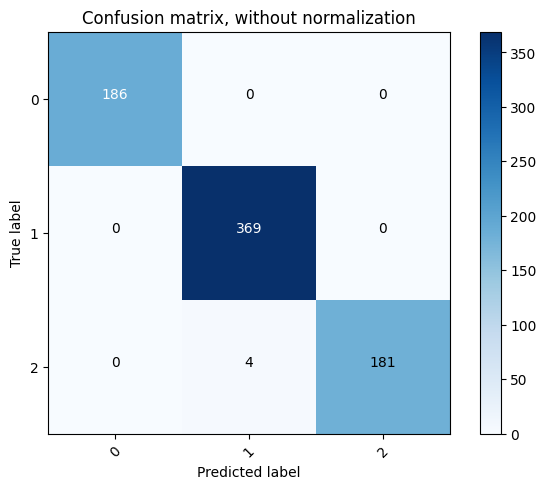

Normalized confusion matrix


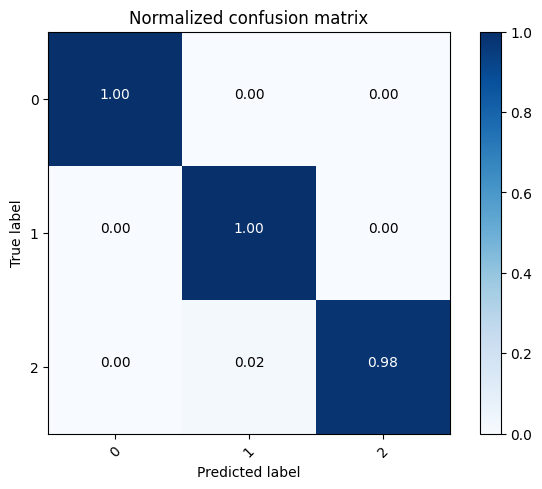

In [95]:
data = dfpred1
target = dfresp1


class_names = ['0','1','2']


labels, counts = np.unique(target, return_counts=True)


predicted_target, actual_target = evaluate_modelKNN(data, target, n_folds=10, n_neighbors = 5)
plot_confusion_matrix(predicted_target, actual_target,class_names)
mpl.pyplot.show()

accuracy =  0.9945945945945946
 precision =  [1.   0.99 1.  ]
 recall =  [1.   1.   0.98]
 specificity =  [[1.   0.99 1.  ]]
 AUC =  [[1.   0.99 0.99]]


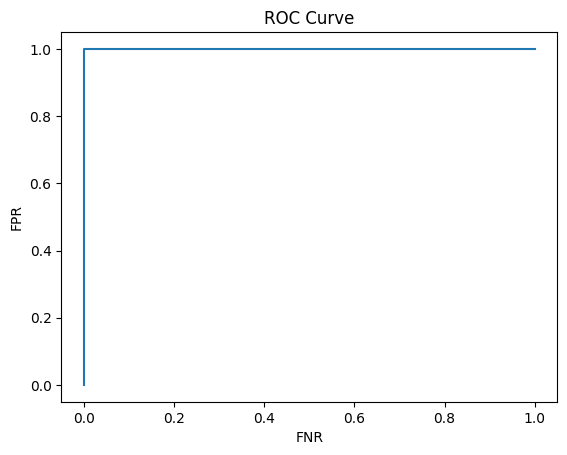

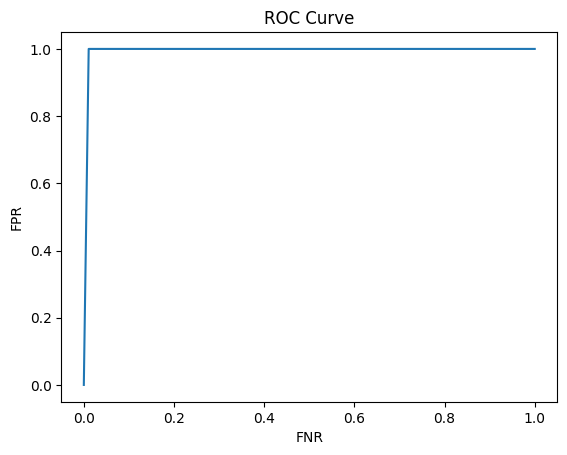

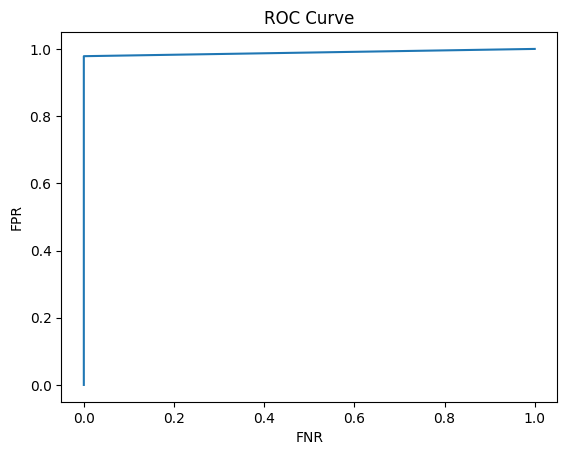

In [96]:


accuracy,precision,recall,specificity,AUC = generate_class_metrix(predicted_target, actual_target,n_classes=3)
print("accuracy = ",accuracy)
print (" precision = ",precision)
print(" recall = ",recall)
print(" specificity = ", specificity.T)
print(" AUC = ",AUC.T)
mpl.pyplot.show()

Quello che possiamo notare è che, anche se il K-NN su questo dataset performa "peggio" della random forest, si avvicina comunque molto ad un classificatore ideale, avendo tutti gli indicatori di performance molto vicini ad 1.

SUPPORT VECTOR MACHINE

I modelli SVM sono basati sull'idea di classificare i dati massimizzando la distanza fra due classi in termini di distanza da un iperpiano separatore. Ciò viene dall'idea che fra le classi si possa sempre trovare un iperpiano che riesce a dividere le classi, mettendo tutti i record ad una certa distanza da questo iperpiano. Quindi si vuole massimizzare questa distanza, il margine(nell'algoritmo il problema di ottimizzazione in realtà è risolto nella sua forma duale). L'idea della separazione lineare potrebbe però non funzionare: in tal caso, o si utilizzano delle penalizzazioni a livello della funzione obbiettivo del duale("regolarizzazione"), oppure, data la non linearità del problema, si possono sfruttare superfici di separazione non lineare; Quello che si fa è sfrutare i "kernel", delle funzioni non lineari particolari che, in caso di situazioni del genere, vengono utilizzate per proiettare la separazione ottenuta su un sottospazio non lineare: in particolare, il kernel sostituisce il termine lineare che misura la distanza fra i dati(prodotto scalare fra i dati <xi,xj>) all'interno della funzione obbiettivo duale, conferendo quindi nonlinearità. Noi useremo un kernel RBF, che sfrutta la funzione K(xi,xj) =  exp(-(||(xi-xj)||_2)^2/(2*sigma^2)), dove sigma è un parametro di dispersione. I modelli SVM possono essere utilizzati anche nella classificazione multiclasse, sfruttando ad esempio(come nella function del pacchetto sklearn) l'approccio one-to-one: si suddivide il problema di classificazione multiclasse in più problemi di classificazione binaria, uno per ogni coppia di classi.

Procediamo a valutare le performance di un modello svm sul dataset, come fatto nei casi precedenti.

SVM con kernel radial basis function.

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_Apprendim

Confusion matrix, without normalization


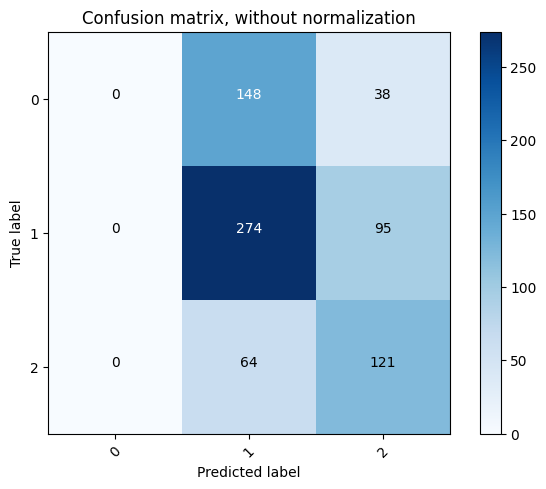

Normalized confusion matrix


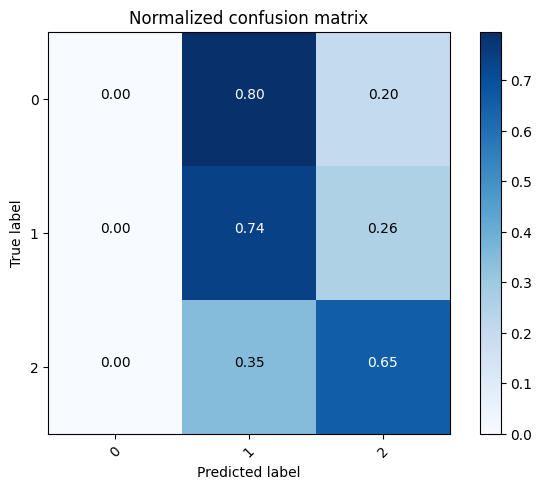

In [97]:
data = dfpred1
target = dfresp1


class_names = ['0','1','2']


labels, counts = np.unique(target, return_counts=True)




predicted_target, actual_target = evaluate_modelSVM(data, target, n_folds=10,kernel='rbf')
plot_confusion_matrix(predicted_target, actual_target,class_names)
mpl.pyplot.show()


accuracy =  0.5337837837837838
 precision =  [0.   0.56 0.48]
 recall =  [0.   0.74 0.65]
 specificity =  [[1.   0.43 0.76]]
 AUC =  [[0.5  0.59 0.71]]


d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



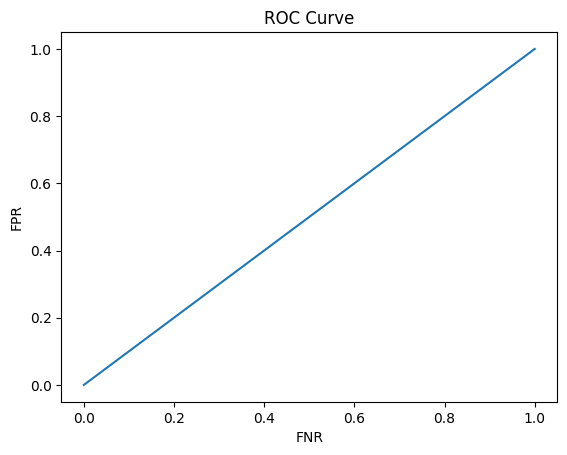

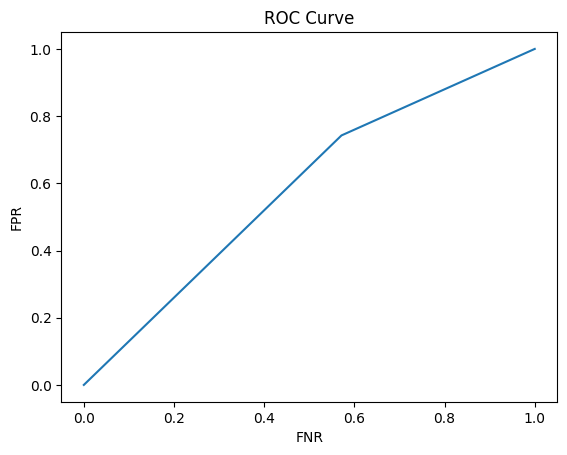

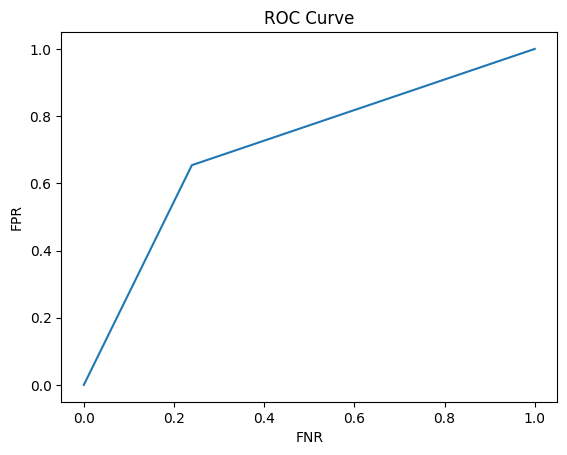

In [98]:

accuracy,precision,recall,specificity,AUC = generate_class_metrix(predicted_target, actual_target,n_classes=3)

print("accuracy = ",accuracy)
print (" precision = ",precision)
print(" recall = ",recall)
print(" specificity = ", specificity.T)
print(" AUC = ",AUC.T)
mpl.pyplot.show()

Quello che si può notare dai risultati ottenuti è che il modello SVM performa in maniera peggiore rispetto agli altri modelli fino ad ora sperimentati. In particolare, esso ha valori degli indicatori di performance che si discostano molto dai valori ideali. Per esempio, il valore dell'AUC (Area under the curve) per la classe 0 è 0.5, il valore considerato idealmente come il valore del classificatore completamente casuale; un altro esempio considerabile è la specifcity per la classe 1, che ha un valore solo di 0.43: ciò vuol dire che di tutti i dati che sono stati etichettati diversamente dalla classe 1 sono davvero non appartenenti ad essa solo il 43% di essi; ciò può essere dovuto anche al fatto che la support vector machine non ha predetto nemmeno un dato come appartenente alla classe 0, quindi ciò che apparteneva alla classe 0 è stato predetto come 1 o 2. 

LINEAR DISCRIMINANT ANALYSIS

LDA CLASSIFICATION

L'ultimo modello di classificazione che andremo ad utilizzare è il modello di Linear Discriminant Analysis. Questo modello è un classificatore bayesiano: l'idea è di minimizzare lo 0-1 loss, che è equivalente a massimizzare la probabilità che il dato appartenga ad una classe; sfruttando il teorema di Bayes, possiamo mostrare che la probabilità ** P[Y = y | X = x] = P[X = x | Y = y] * P[Y = y]/ P[X = x] , dove Y è il responso da classificare ed X il predittore. In termini di pdf possiamo dire quindi che f(y|x) è direttamente proporzionale a  f(x|y) * f(y) , dove f(y) sarà la distribuzione a priori, mentre f(y|x) sarà la distribuzione posterior, a cui siamo interessati e f(x|y) è la verosimiglianza(likelyhood) di ottenere un certo vettore x conoscendo il valore di y. Nella LDA si assume la distribuzione prior discreta assegnata(sulle classi), con probabilità a_y per la classe y; la likelyhood invece sarà una distribuzione normale(multivariata) con i parametri caratterizzanti(vettore medie e matrice di Varianza-Covarianza) dipendenti dalla classe y. Ciò ci riconduce quindi alla massimizzazione della posterior: si parte dal caso di classificazione binaria, dove si confrontano le due probabilità posterior ottenute, risolvendo quindi la disequazione ** a_0 * g(x|0) - a_1 * g(x|1) > 0 ** : se la disequazione è rispettata, allora si assegna la classe 0, altrimenti la classe 1. **d(x) = a_y*g(x|y) ** è detta Quadratic discriminant function, e in generale essa genera un decision boundary( l'insieme delle x tali che ** a_0 * g(x|0) = a_1 * g(x|1) **) e una disequazione contenenti una funzione quadratica. Nel caso particolare in cui l'unico parametro della likelyhood che dipende dalla y è il vettore delle medie della distribuzione normale, allora il decision boundary e la disequazione diventano lineari, determinando quindi la classificazione con LDA.  L'algoritmo LDA inoltre è generalizzabile alla classificazione multiclasse.

Come nei casi precedenti, ora procederemo a valutare le performance dell'algoritmo LDA sul nostro dataset.

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_Apprendim

Confusion matrix, without normalization


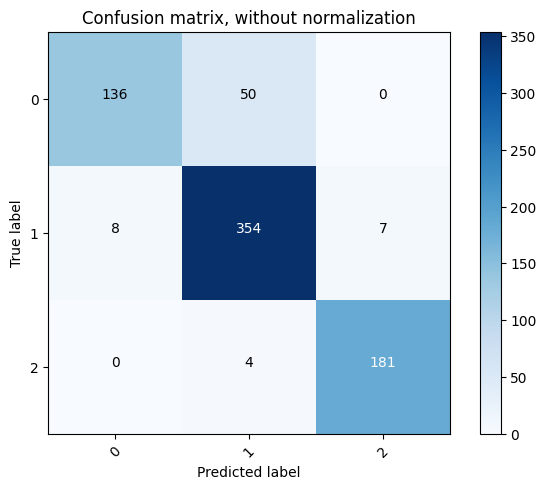

Normalized confusion matrix


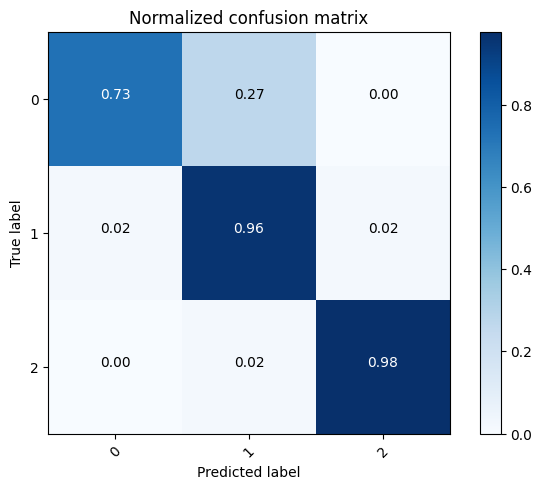

In [99]:
data = dfpred1
target = dfresp1


class_names = ['0','1','2']


labels, counts = np.unique(target, return_counts=True)




predicted_target, actual_target = evaluate_modelLDA(data, target, n_folds=10)
plot_confusion_matrix(predicted_target, actual_target,class_names)
mpl.pyplot.show()


accuracy =  0.9067567567567567
 precision =  [0.94 0.87 0.96]
 recall =  [0.73 0.96 0.98]
 specificity =  [[0.99 0.85 0.99]]
 AUC =  [[0.86 0.91 0.98]]


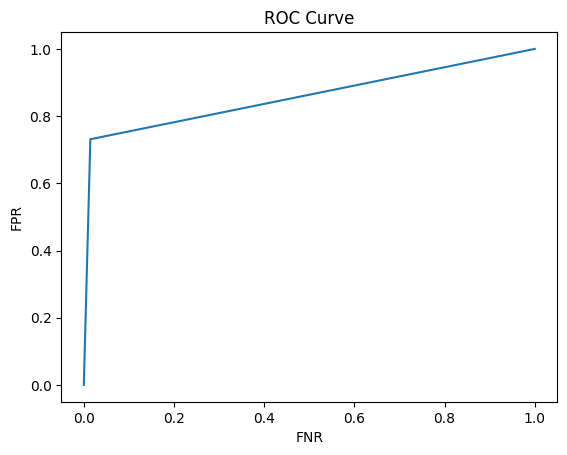

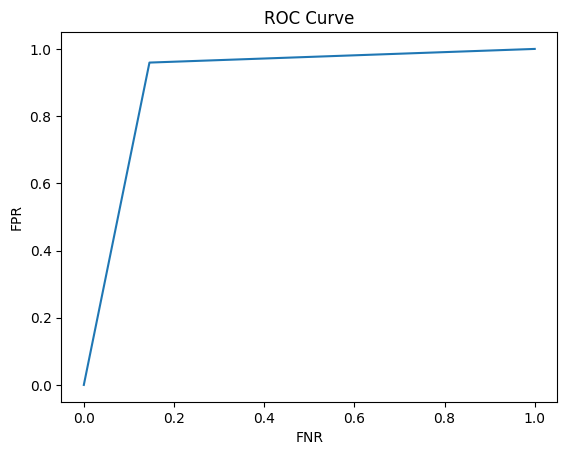

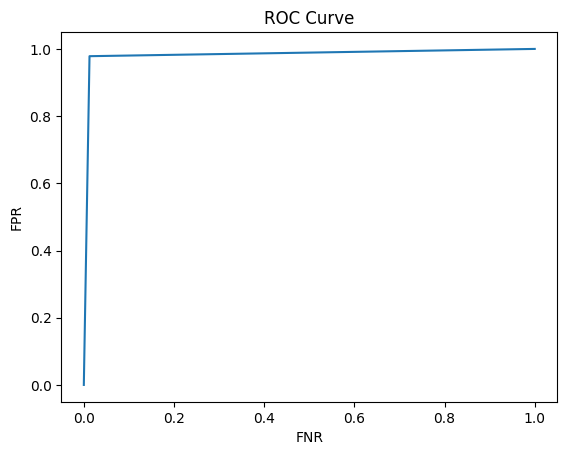

In [100]:

accuracy,precision,recall,specificity,AUC = generate_class_metrix(predicted_target, actual_target,n_classes=3)

print("accuracy = ",accuracy)
print (" precision = ",precision)
print(" recall = ",recall)
print(" specificity = ", specificity.T)
print(" AUC = ",AUC.T)
mpl.pyplot.show()

Quest'ultimo modello ha delle buone performances, peggiori rispetto a RF e K-NN ma comunque buone. I maggiori problemi di classificazione avvengono nella classificazione della classe 0, che nel 23% delle volte viene classificata come classe 1.

Volendo fare un sommario di tutto, possiamo dire che in performance di Classificazione il peggior classificatore che abbiamo fittato è stato il modello SVM, mentre il migliore è stata la Random Forest.

LDA DIMENSION REDUCTION

Il modello LDA, può effettuare una riduzione della dimensionalità del dataset: riproietta i dati in un nuovo spazio di dimensione corrispondente al numero di classi - 1 , in cui le classi risultano perfettamente separate, utilizzando la decomposizione SVD. Quindi noi abbiamo voluto mostrare l'effetto di questa separazione sul nostro dataset, con la nostra variabile categorica utilizzata per la classificazione. Quindi abbiamo preso una parte dei dati, ed abbiamo fittato il modello LDA; poi abbiamo riproiettato i dati nel suo sottospazio(in questo caso di 2 dimensioni, poichè abbiamo 3 classi). 

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



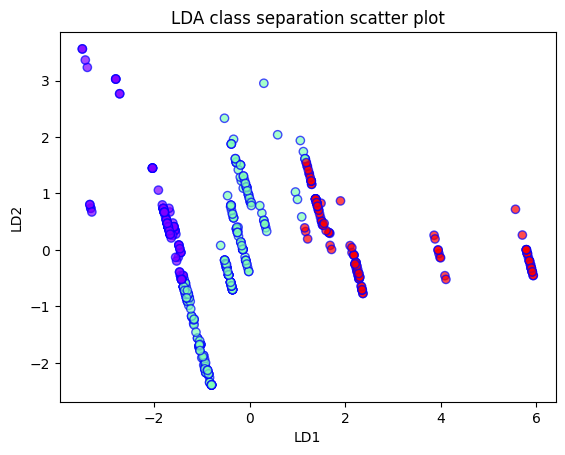

In [101]:
X_train, X_test, y_train, y_test = ms.train_test_split(data,target,test_size=0.33,random_state=1)
LDAclassifier1 = da.LinearDiscriminantAnalysis()
X_lda = LDAclassifier1.fit_transform(X_train, y_train)

#trasformedX = LDAclassifier1.transform(X_test)

le = prep.LabelEncoder()
y = le.fit_transform(y_train)

mpl.pyplot.title('LDA class separation scatter plot')
mpl.pyplot.xlabel('LD1')
mpl.pyplot.ylabel('LD2')
mpl.pyplot.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)
mpl.pyplot.show()

Dopo aver diminuito la dimensione e fittato il modello, vogliamo provare a vedere come performa la classificazione sul dataset trasformato.

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_Apprendim

Confusion matrix, without normalization


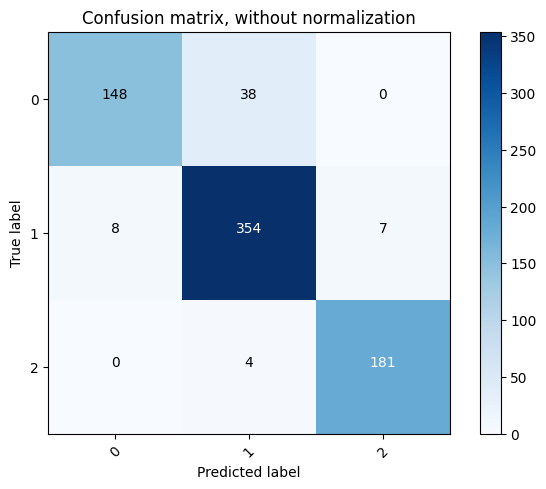

Normalized confusion matrix


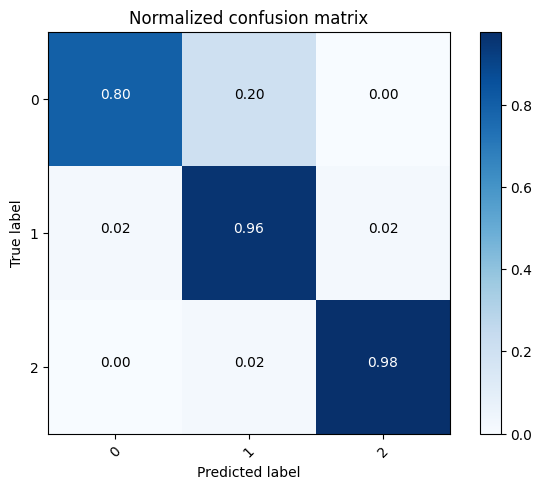

In [102]:

data = LDAclassifier1.transform(dfpred1)
data = pd.DataFrame(data,columns=['LD1','LD2'])
target = dfresp1


class_names = ['0','1','2']


labels, counts = np.unique(target, return_counts=True)




predicted_target, actual_target = evaluate_modelLDA(data, target, n_folds=10)
plot_confusion_matrix(predicted_target, actual_target,class_names)

mpl.pyplot.show()

accuracy =  0.922972972972973
 precision =  [0.95 0.89 0.96]
 recall =  [0.8  0.96 0.98]
 specificity =  [[0.99 0.89 0.99]]
 AUC =  [[0.89 0.92 0.98]]


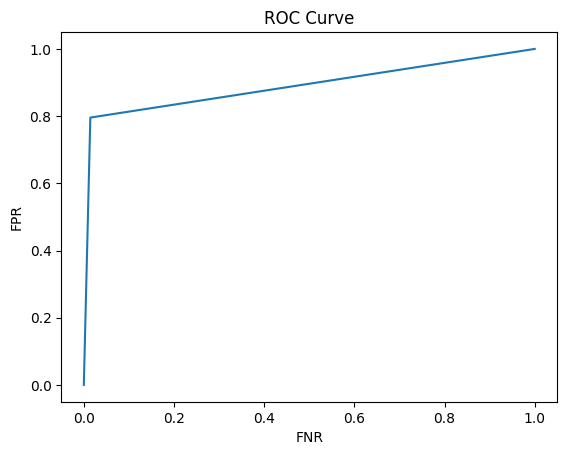

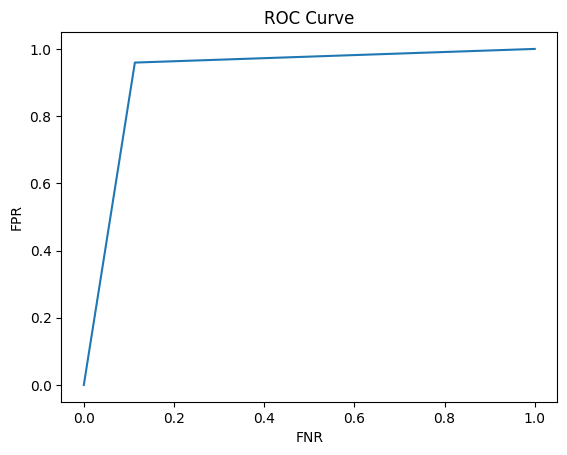

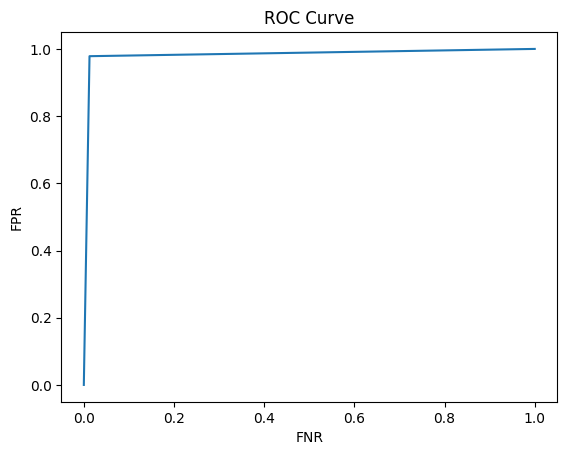

In [103]:
accuracy,precision,recall,specificity,AUC = generate_class_metrix(predicted_target, actual_target,n_classes=3)

print("accuracy = ",accuracy)
print (" precision = ",precision)
print(" recall = ",recall)
print(" specificity = ", specificity.T)
print(" AUC = ",AUC.T)
mpl.pyplot.show()

Quello che possiamo notare è che le performance di classificazione dell'LDA fittata sul dataset trasformato sono migliori rispetto al modello fittato sul dataset originale.

Proviamo ora a fittare e testare il nostro classificatore peggiore, il modello SVM.

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_ApprendimentoStatistico_ML\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

d:\Users\Giuseppe Biagio\Downloads\GiuseppeBiagio_Lapadula_s292220_Apprendim

Confusion matrix, without normalization


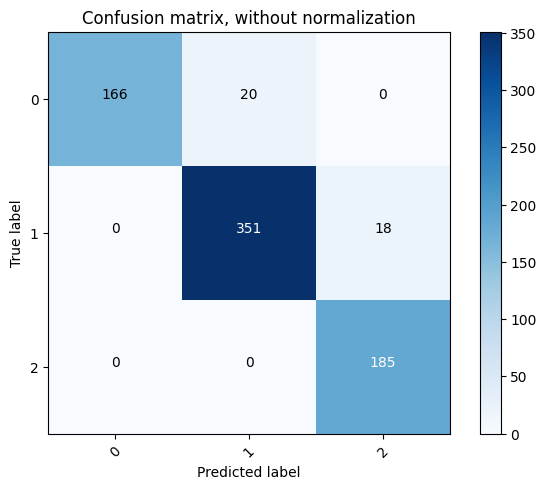

Normalized confusion matrix


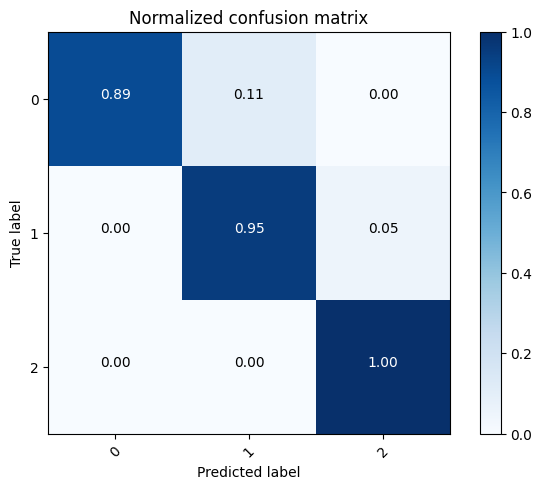

In [104]:
data = LDAclassifier1.transform(dfpred1)
data = pd.DataFrame(data,columns=['LD1','LD2'])
target = dfresp1




class_names = ['0','1','2']


labels, counts = np.unique(target, return_counts=True)




predicted_target, actual_target = evaluate_modelSVM(data, target, n_folds=10,kernel='rbf')
plot_confusion_matrix(predicted_target, actual_target,class_names)

mpl.pyplot.show()

accuracy =  0.9486486486486486
 precision =  [1.   0.95 0.91]
 recall =  [0.89 0.95 1.  ]
 specificity =  [[1.   0.95 0.97]]
 AUC =  [[0.95 0.95 0.98]]


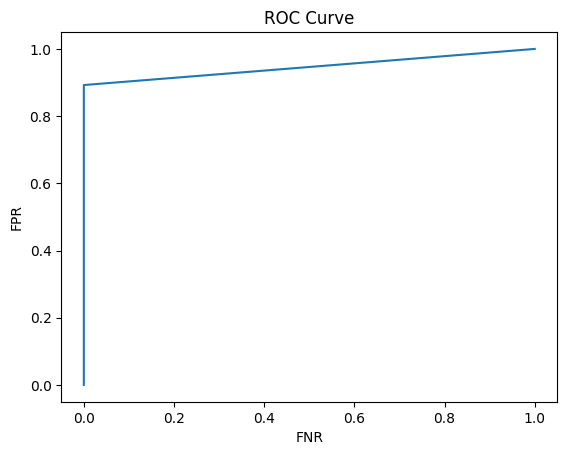

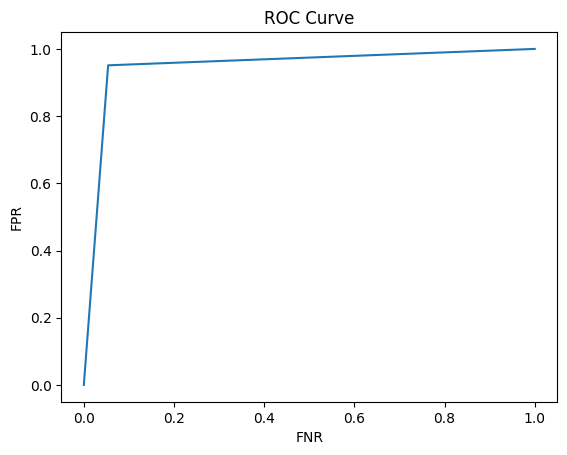

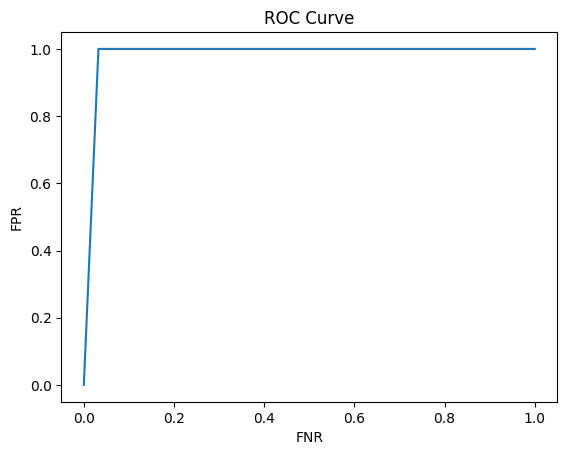

In [105]:
accuracy,precision,recall,specificity,AUC = generate_class_metrix(predicted_target, actual_target,n_classes=3)

print("accuracy = ",accuracy)
print (" precision = ",precision)
print(" recall = ",recall)
print(" specificity = ", specificity.T)
print(" AUC = ",AUC.T)
mpl.pyplot.show()

Possiamo notare come la riduzione di dimensionalità effettuata con il modello LDA ha portato ad un netto miglioramento delle performances di classificazione del modello SVM.